<a href="https://colab.research.google.com/github/arina19-2000/unimi/blob/main/tesi/adult_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab


In [27]:
import numpy as np
import pandas as pd
from scipy import stats
df_adults = pd.read_excel('dfa.xlsx')

In [28]:
df_adults

,Unnamed: 0,adopt_age,origin_region,scolarizzato_paese_origine_italia_inclusa,presenza_certificazione_sensi_l170_2010,difficoltà_rendimentoapprendimento_spinto_cambiare_tipologia_indirizzo_scuola_secondaria_secondo_grado_superiore,fatto_anni_istruzione_universitaria_afam_senza_conseguire_titolo,già_indipendenza_economica,attualmente_lavora,qual_titolo_studio_massimo_conseguito_madre,...,school_experience_primary_encoded,prima_classe_frequenza_scuola,origin_region.1,dovuto_ripetere_anni_padre,dovuto_ripetere_anni_madre,dovuto_ripetere_anni_superiore,adozione_int,valutazione_voto60,valutazione_voto100,qual_titolo_studio_massimo_conseguito
0,2,1,78,0.0,0.0,NaN,NaN,1.0,1.0,1.0,...,3.0,4.0,78,NaN,NaN,NaN,0,0,0,5.0
1,4,5,78,1.0,1.0,0.0,0.0,0.0,0.0,5.0,...,3.0,2.0,78,0.0,1.0,1.0,0,0,76,3.0
2,5,15,118,0.0,1.0,0.0,0.0,0.0,0.0,6.0,...,3.0,2.0,118,0.0,0.0,0.0,1,45,0,3.0
3,6,0,78,0.0,0.0,NaN,NaN,0.0,1.0,5.0,...,2.0,1.0,78,0.0,0.0,NaN,0,0,0,6.0
4,7,3,78,1.0,0.0,0.0,0.0,1.0,1.0,3.0,...,2.0,2.0,78,0.0,0.0,0.0,0,0,70,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,772,6,63,0.0,0.0,NaN,NaN,NaN,1.0,6.0,...,1.0,3.0,63,0.0,1.0,NaN,1,0,0,1.0
369,773,7,118,0.0,0.0,0.0,0.0,0.0,1.0,6.0,...,3.0,4.0,118,0.0,1.0,1.0,1,60,0,3.0
370,778,6,7,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,2.0,2.0,7,1.0,0.0,0.0,1,74,0,3.0
371,783,2,118,NaN,0.0,NaN,NaN,0.0,0.0,NaN,...,2.0,2.0,118,NaN,NaN,NaN,1,0,0,5.0


In [29]:
df_adults['qual_titolo_studio_massimo_conseguito'] = df_adults['qual_titolo_studio_massimo_conseguito'].replace({7: 6, 8: 6, 1: 2,  0.5: 2})
df_adults['dovuto_ripetere_anni_padre'] = df_adults['dovuto_ripetere_anni_padre'].replace({1:2})

1. Nessun titolo/Licenza elementare o frequentazione della sola scuola primaria
2. Licenza di scuola secondaria di primo grado (precedentemente denominata licenza media inferiore)
3. Titolo di diploma di qualifica professionale che non permette l’accesso all’università (3 o 4 anni)
4. Titolo di scuola secondaria di secondo grado (denominata precedentemente scuola superiore) che permette l’iscrizione all’università (5 anni)
5. Titolo post-secondario non terziario (IFTS)
6. Titolo di studio universitario
7. Titolo di studio post-universitario (Master, Scuola di perfezionamento, ecc.)
8. Dottorato di ricerca

In [30]:
df_adults['qual_titolo_studio_massimo_conseguito'].value_counts()

,count
qual_titolo_studio_massimo_conseguito,
3.0,226
2.0,85
5.0,43
4.0,10
6.0,9


In [31]:
df_adults["qual_titolo_studio_massimo_conseguito"] = df_adults["qual_titolo_studio_massimo_conseguito"].astype(int)

In [32]:
df_adults = df_adults.drop(columns=['Unnamed: 0','origin_region.1'])
df_adults = df_adults[df_adults['qual_titolo_studio_massimo_conseguito'] != 0]

In [33]:
!pip install ydata_profiling

In [34]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df_adults, title="Profiling Report")
# profile.to_widgets()

In [35]:
df_adults['valutazione_voto100'] = df_adults['valutazione_voto60'].where(df_adults['valutazione_voto60'] != 0, df_adults['valutazione_voto100'])
df_adults.drop(columns=['valutazione_voto60'], inplace=True)

In [36]:
df_adults['prima_classe_frequenza_scuola'].value_counts()

,count
prima_classe_frequenza_scuola,
2.0,85
3.0,82
4.0,74
1.0,48
6.0,25
5.0,19
7.0,16
0.0,13
8.0,3


In [37]:
mean_adopt_age = df_adults.loc[df_adults['adopt_age'] <= 18, 'adopt_age'].mean()
df_adults.loc[df_adults['adopt_age'] > 18, 'adopt_age'] = mean_adopt_age
print(df_adults['adopt_age'].value_counts())

adopt_age
0.000000     45
7.000000     37
2.000000     36
6.000000     35
3.000000     33
1.000000     32
5.000000     32
8.000000     27
9.000000     27
4.000000     24
10.000000    18
11.000000     9
12.000000     5
5.054201      4
18.000000     3
13.000000     3
15.000000     2
16.000000     1
Name: count, dtype: int64


<ipython-input-37-0fcfecec0fee>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.05420054200542' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_adults.loc[df_adults['adopt_age'] > 18, 'adopt_age'] = mean_adopt_age


In [38]:
from sklearn.preprocessing import StandardScaler

target_variable = "qual_titolo_studio_massimo_conseguito"
numeric_vars = ["adopt_age", "valutazione_voto60", "valutazione_voto100", "prima_classe_frequenza_scuola"]

numeric_vars = [col for col in numeric_vars if col in df_adults.columns]
categorical_vars = [col for col in df_adults.columns if col not in numeric_vars + [target_variable]]
df_cleaned = df_adults.dropna(axis=1, thresh=len(df_adults) * 0.7).copy()

for col in numeric_vars:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

if numeric_vars:
    scaler = StandardScaler()
    df_cleaned[numeric_vars] = scaler.fit_transform(df_cleaned[numeric_vars])

for col in categorical_vars:
    if col in df_cleaned.columns:
        if df_cleaned[col].dropna().shape[0] > 0:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].dropna().mode()[0])

print("Missing values:\n", df_cleaned.isnull().sum().sum())

Missing values:
 0


In [39]:
from scipy.stats import zscore

target_column = "qual_titolo_studio_massimo_conseguito"
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_column]
z_scores = df_cleaned[numeric_cols].apply(zscore, nan_policy='omit')
outlier_mask = (z_scores > 3) | (z_scores < -3)
for col in numeric_cols:
    upper_bound = df_cleaned[col].mean() + 3 * df_cleaned[col].std()
    lower_bound = df_cleaned[col].mean() - 3 * df_cleaned[col].std()

    df_cleaned.loc[outlier_mask[col], col] = np.clip(df_cleaned.loc[outlier_mask[col], col], lower_bound, upper_bound)

z_scores_after = df_cleaned[numeric_cols].apply(zscore, nan_policy='omit')
outliers_remaining = (z_scores_after > 3) | (z_scores_after < -3)
outlier_counts_after = outliers_remaining.sum()


In [40]:
from scipy.stats import zscore

outliers = (z_scores > 3) | (z_scores < -3)
outlier_counts = outliers.sum()

# Summarize outliers
outlier_summary = pd.DataFrame({
    "Column": numeric_cols,
    "Outlier Count": outlier_counts
}).sort_values(by="Outlier Count", ascending=False)
print(outlier_summary)

                                                                                               Column  \
dovuto_ripetere_anni_padre                                                 dovuto_ripetere_anni_padre   
dovuto_ripetere_anni_madre                                                 dovuto_ripetere_anni_madre   
adopt_age                                                                                   adopt_age   
prima_classe_frequenza_scuola                                           prima_classe_frequenza_scuola   
origin_region                                                                           origin_region   
adozione_int                                                                             adozione_int   
school_experience_primary_encoded                                   school_experience_primary_encoded   
school_experience_secondary_encoded                               school_experience_secondary_encoded   
genere_fem                                             

In [41]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

def gauss_markov_assumptions(X, y):

    # 1. Independence of Errors: Durbin-Watson test
    X_with_intercept = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_intercept).fit()
    dw_statistic = sm.stats.durbin_watson(ols_model.resid)
    print(f"Durbin-Watson statistic: {dw_statistic}")


    # 2. Breusch-Pagan Test for homoscedasticity
    bp_test = sms.het_breuschpagan(ols_model.resid, ols_model.model.exog)
    print(f"Breusch-Pagan Test p-value: {bp_test[1]}")

    # 3. VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data)

X = df_cleaned.drop(columns=['qual_titolo_studio_massimo_conseguito'])
y = df_cleaned['qual_titolo_studio_massimo_conseguito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
gauss_markov_assumptions(X_train, y_train)

Durbin-Watson statistic: 2.0463710904184387
Breusch-Pagan Test p-value: 5.450354718709199e-18

Variance Inflation Factors (VIF):
                                              feature        VIF
0                                           adopt_age   1.911917
1                                       origin_region  10.166534
2           scolarizzato_paese_origine_italia_inclusa   2.425743
3             presenza_certificazione_sensi_l170_2010   1.331886
4                          già_indipendenza_economica   2.381690
5                                  attualmente_lavora   3.052463
6         qual_titolo_studio_massimo_conseguito_madre  10.012817
7         qual_titolo_studio_massimo_conseguito_padre   8.391858
8   presenza_patologie_certificate_sensi_104_comma...   1.210326
9         descrizione_nucleo_familiare_figlio_encoded   5.739836
10                                  sibling_adopt_yes   1.576866
11                         fatto_esperienze_allestero   1.414613
12                        

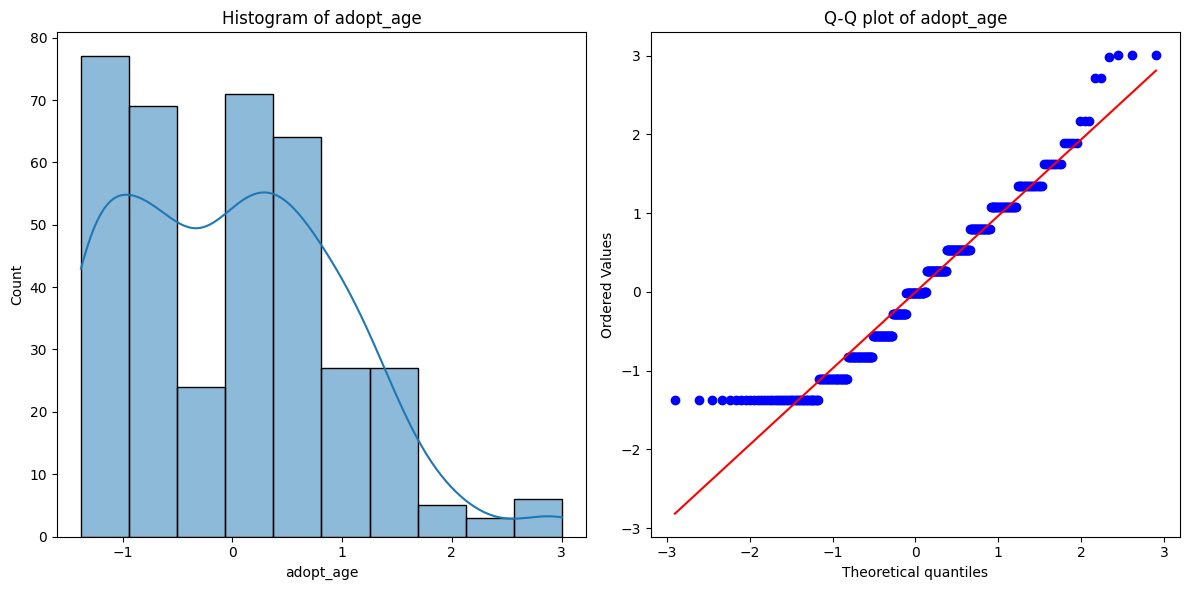

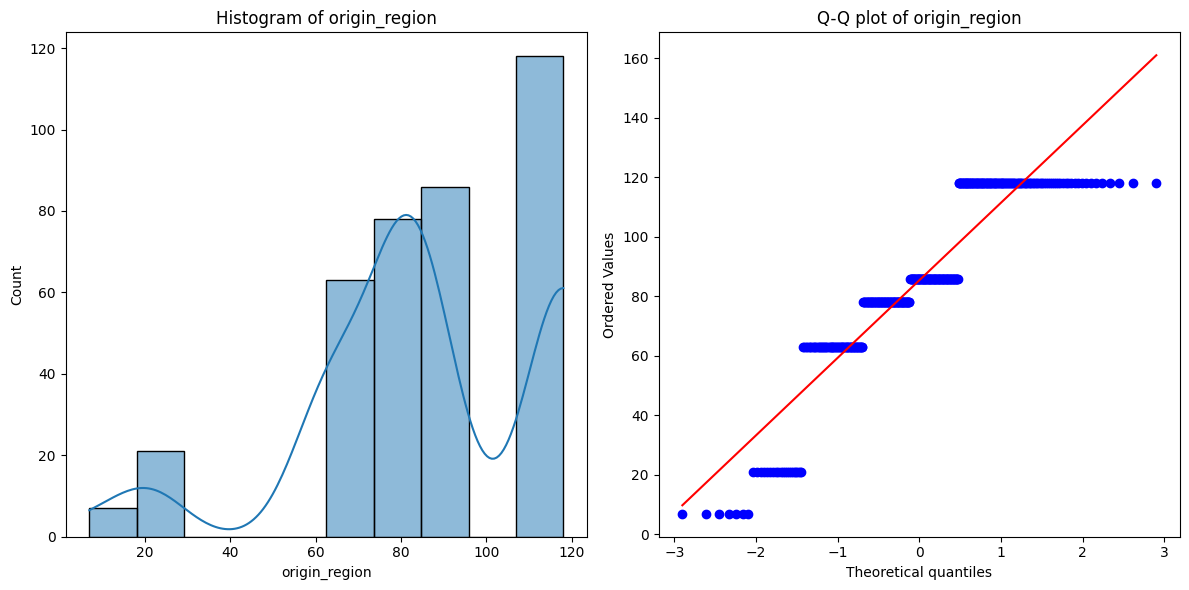

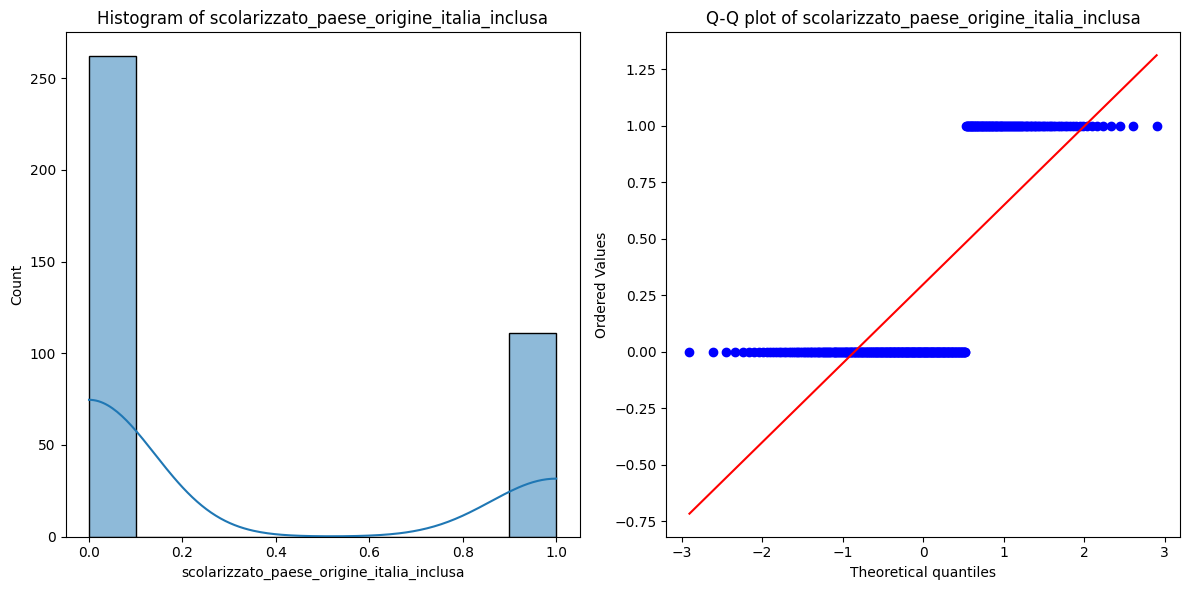

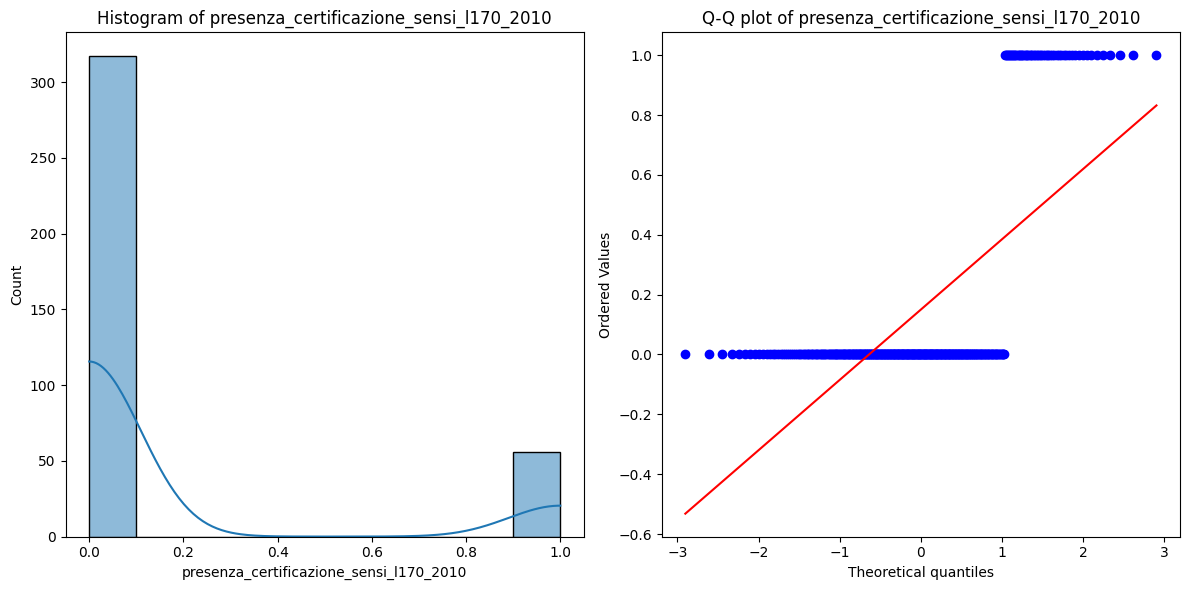

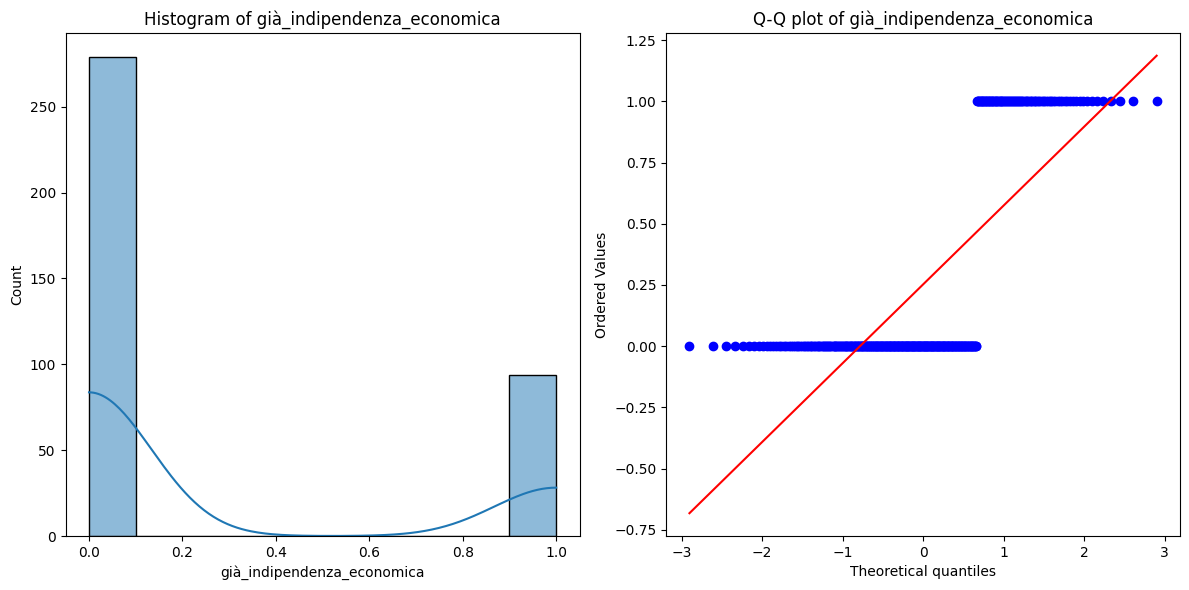

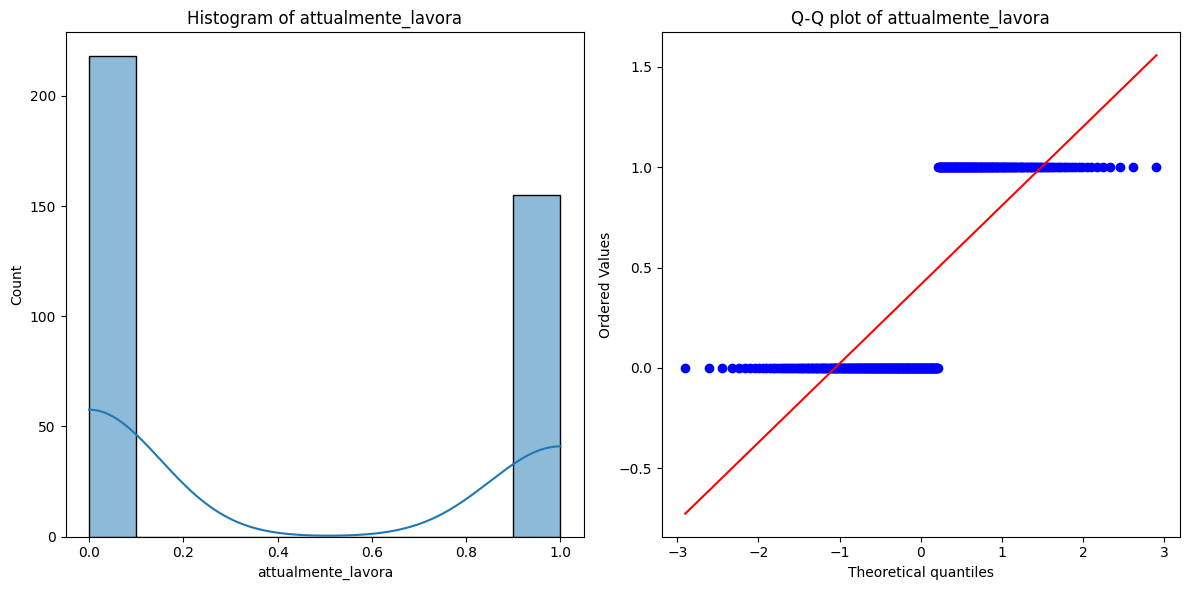

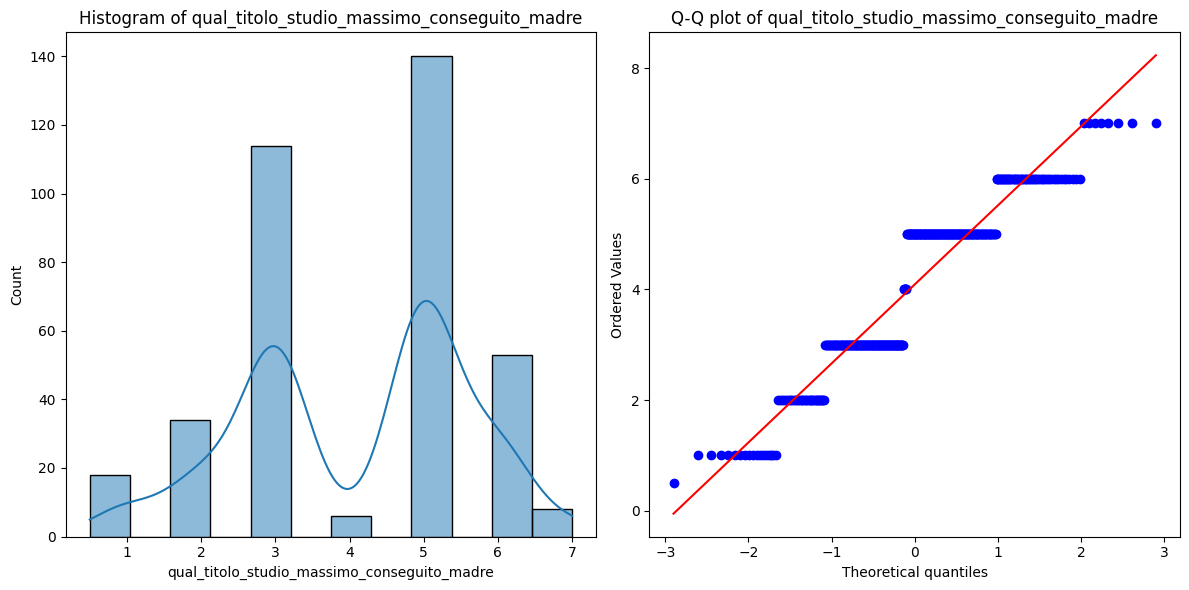

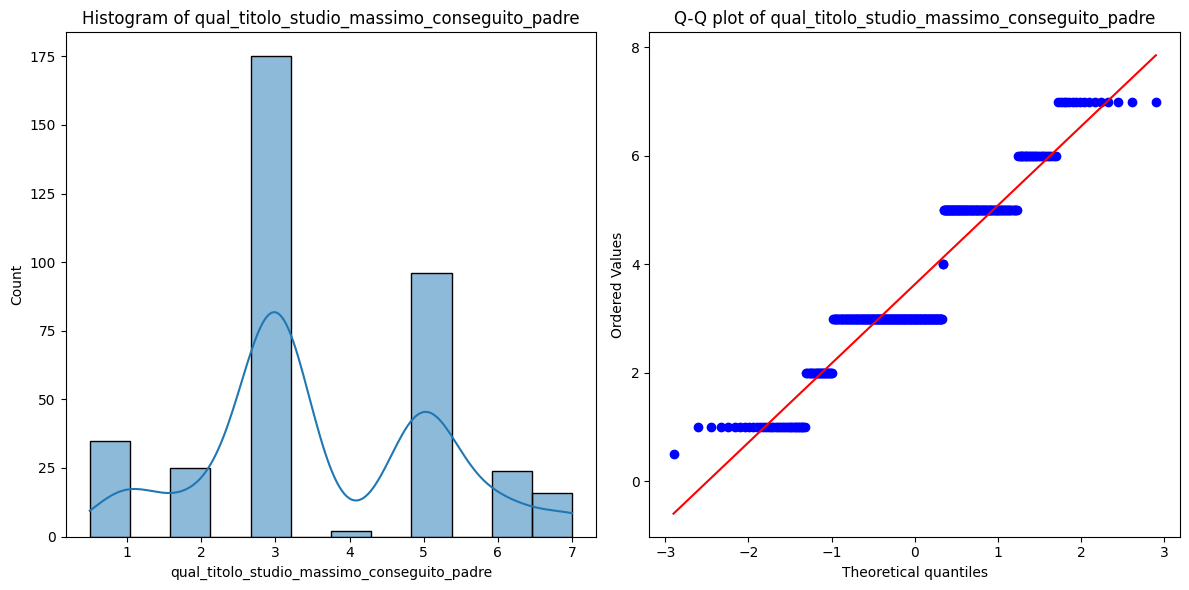

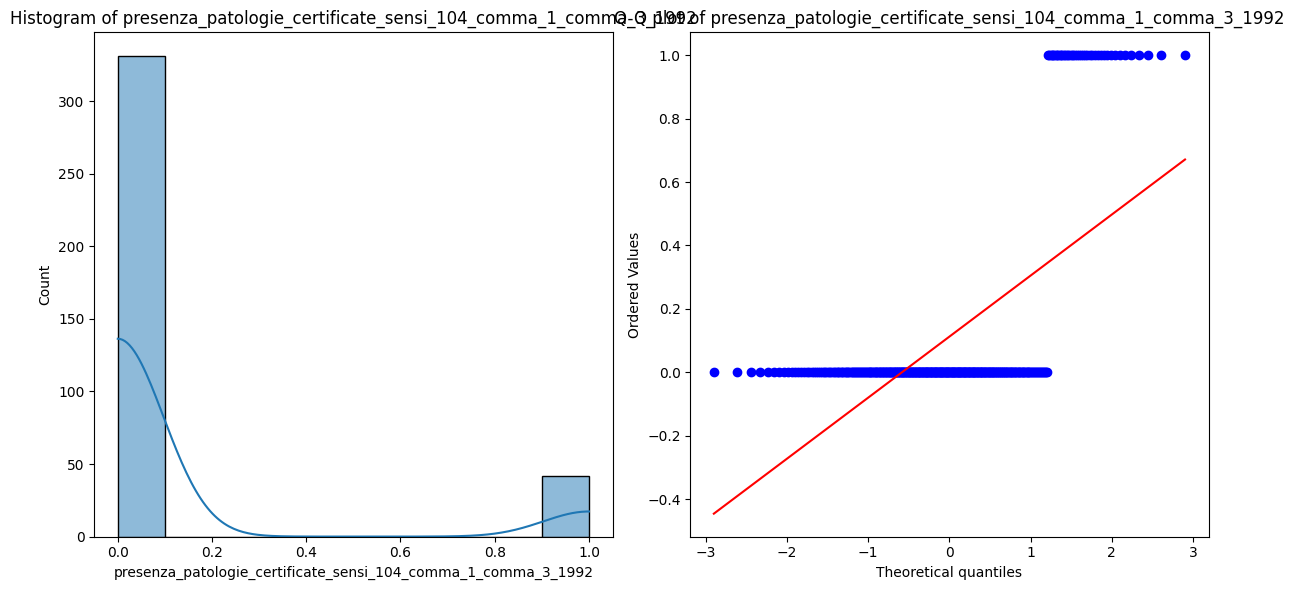

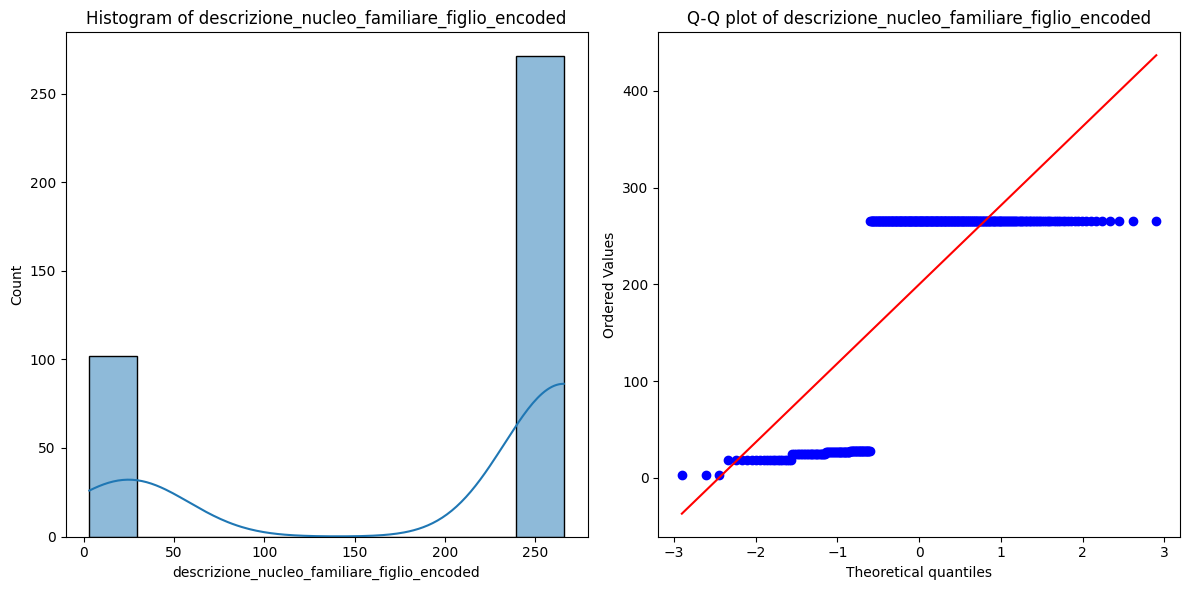

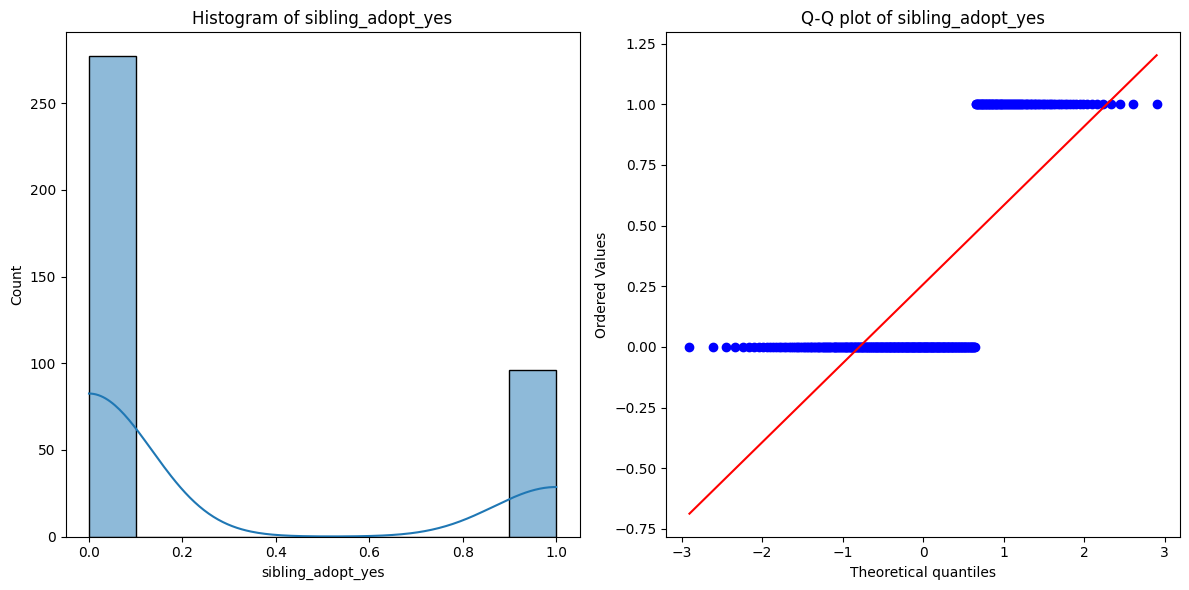

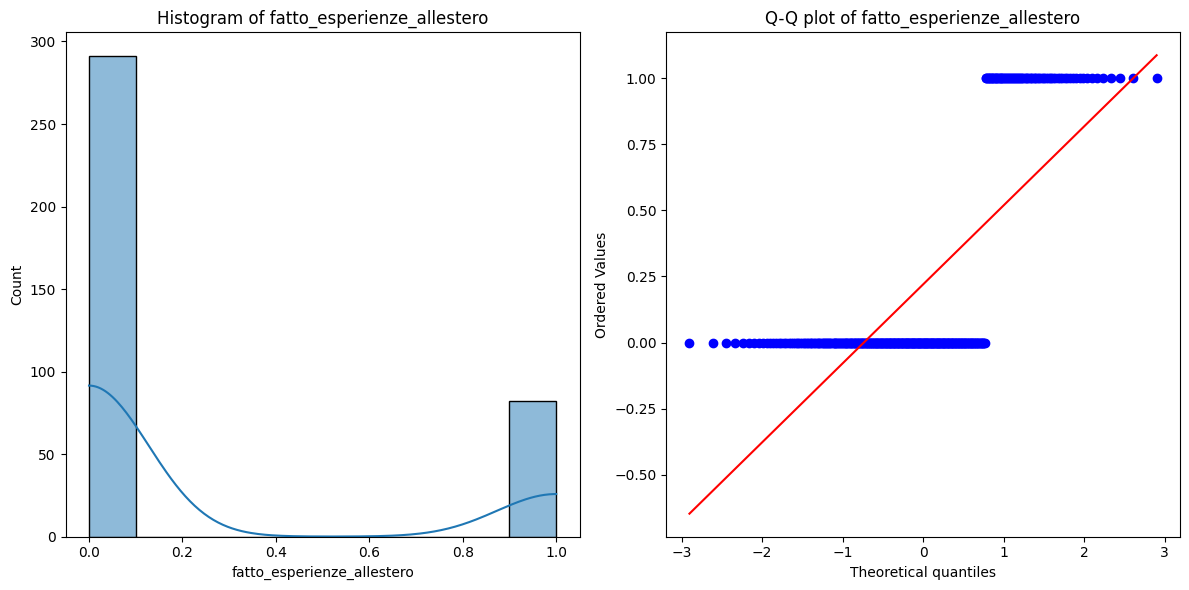

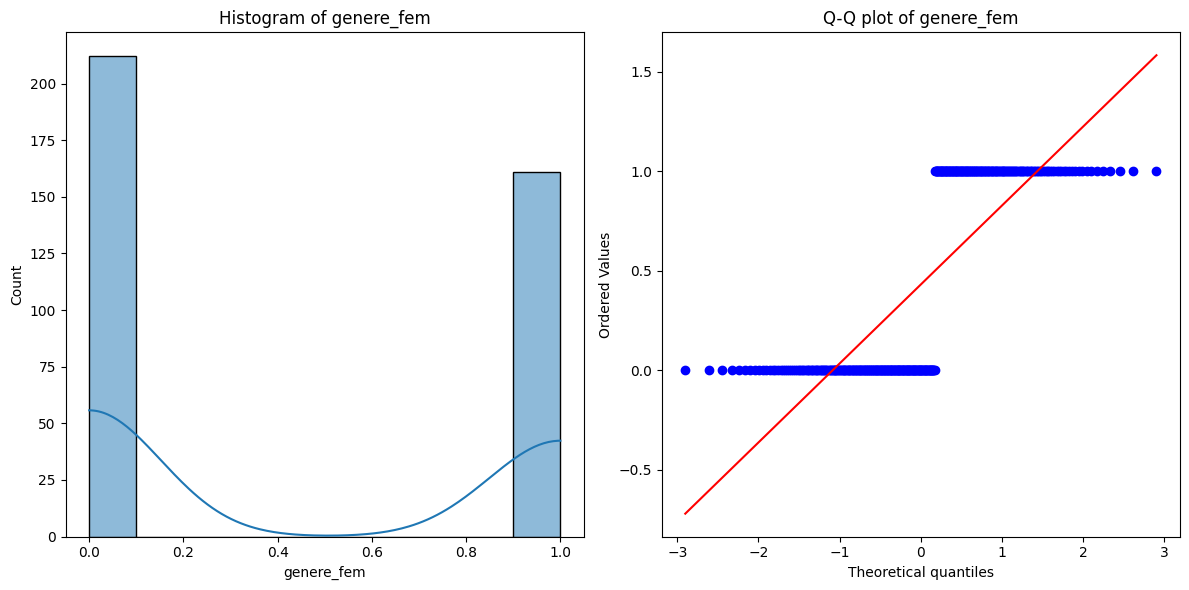

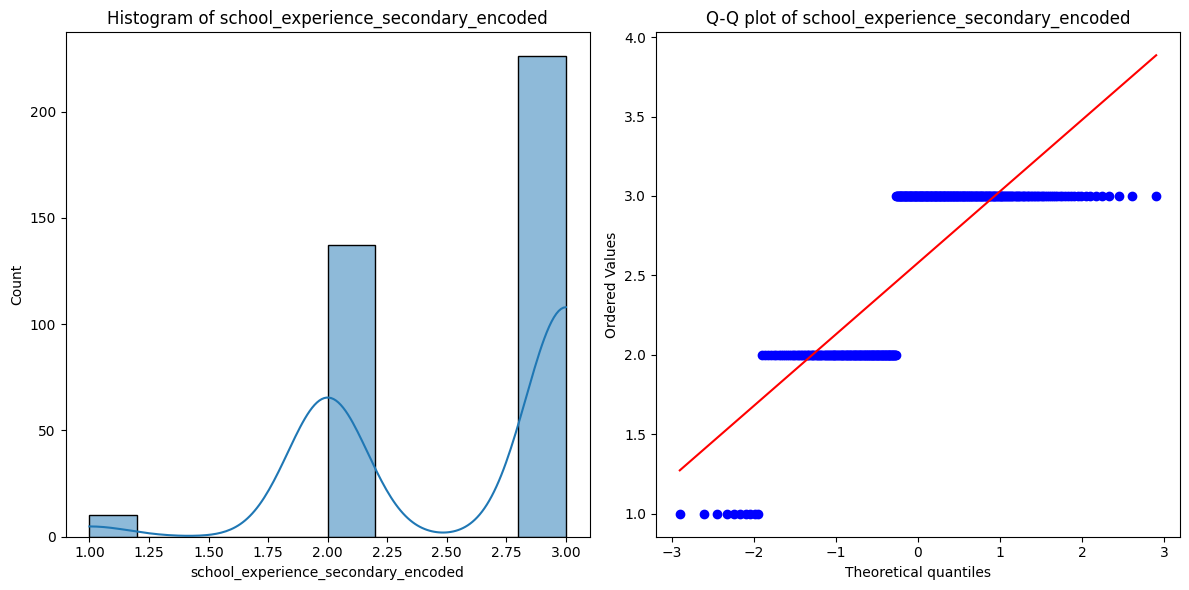

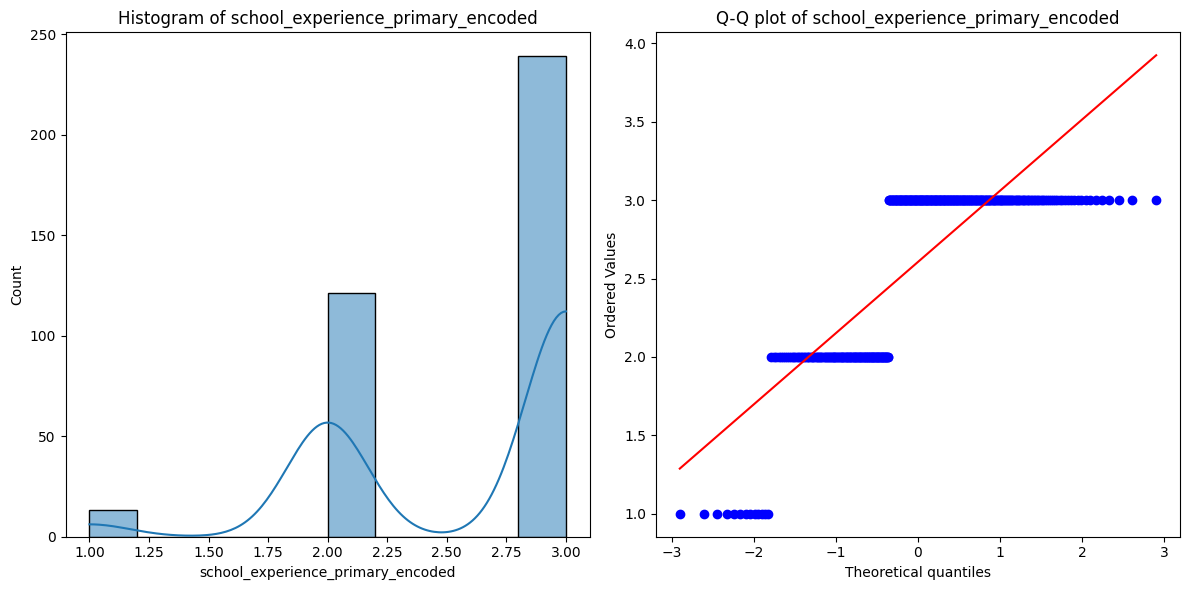

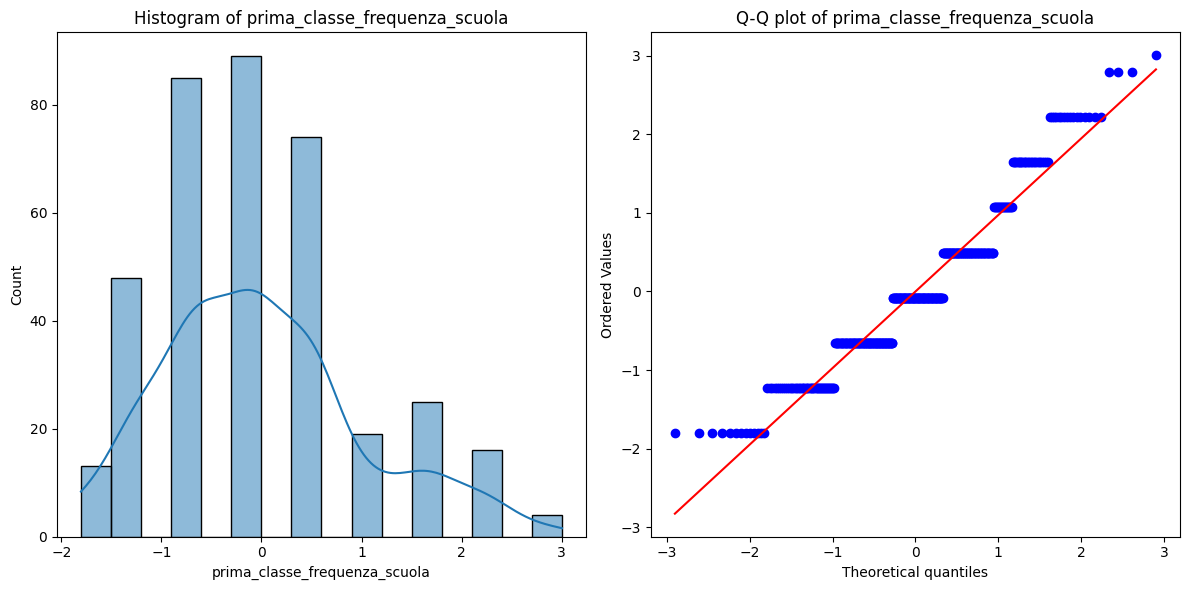

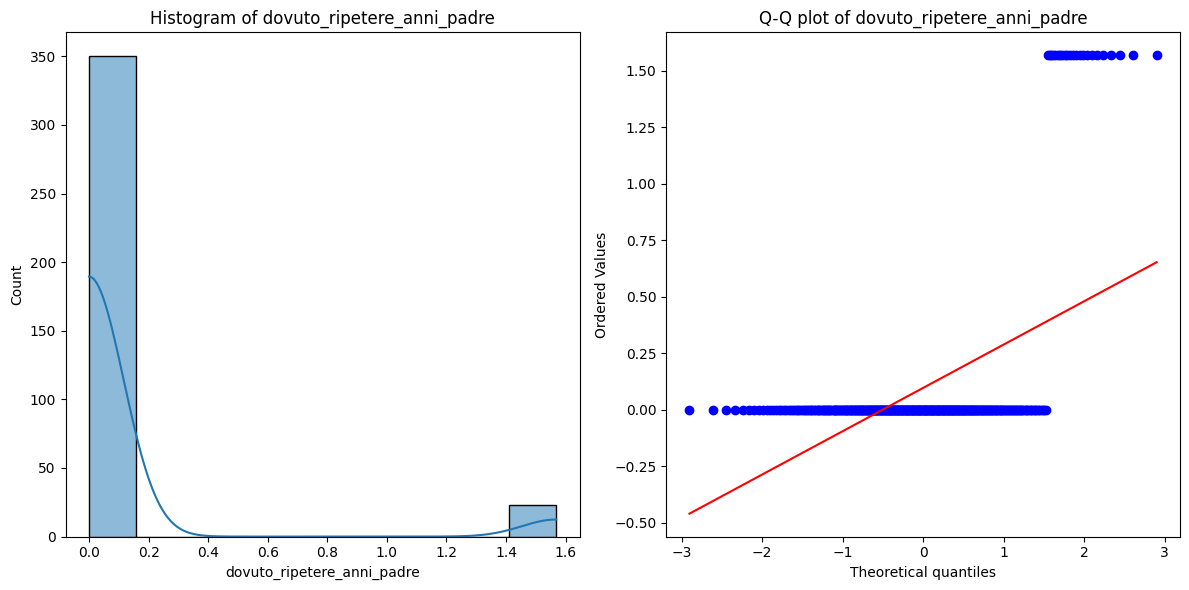

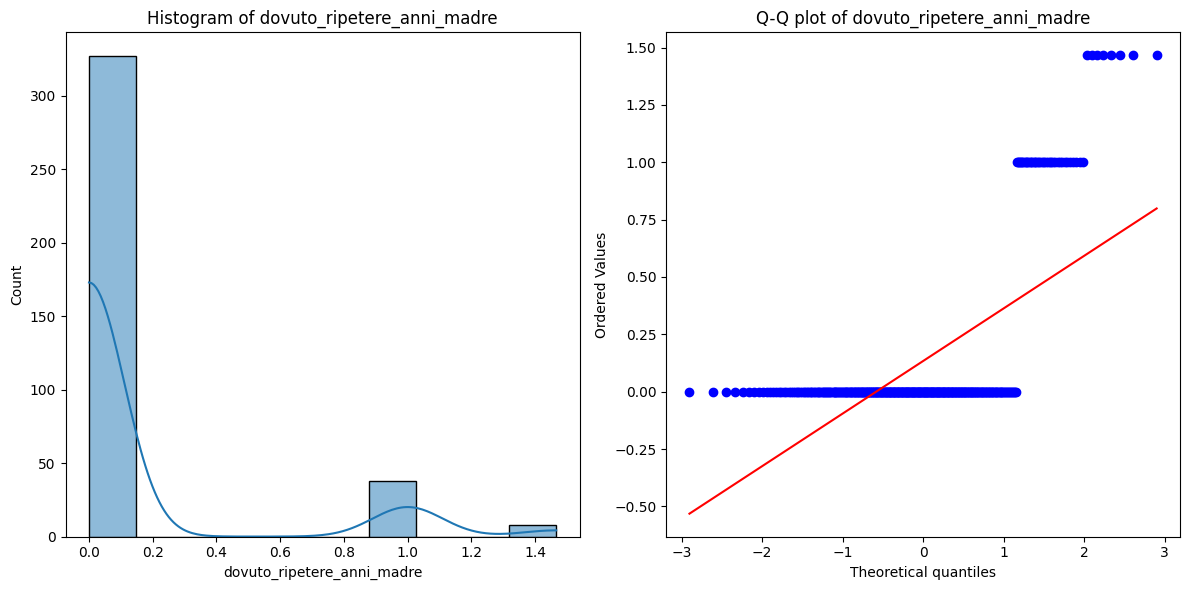

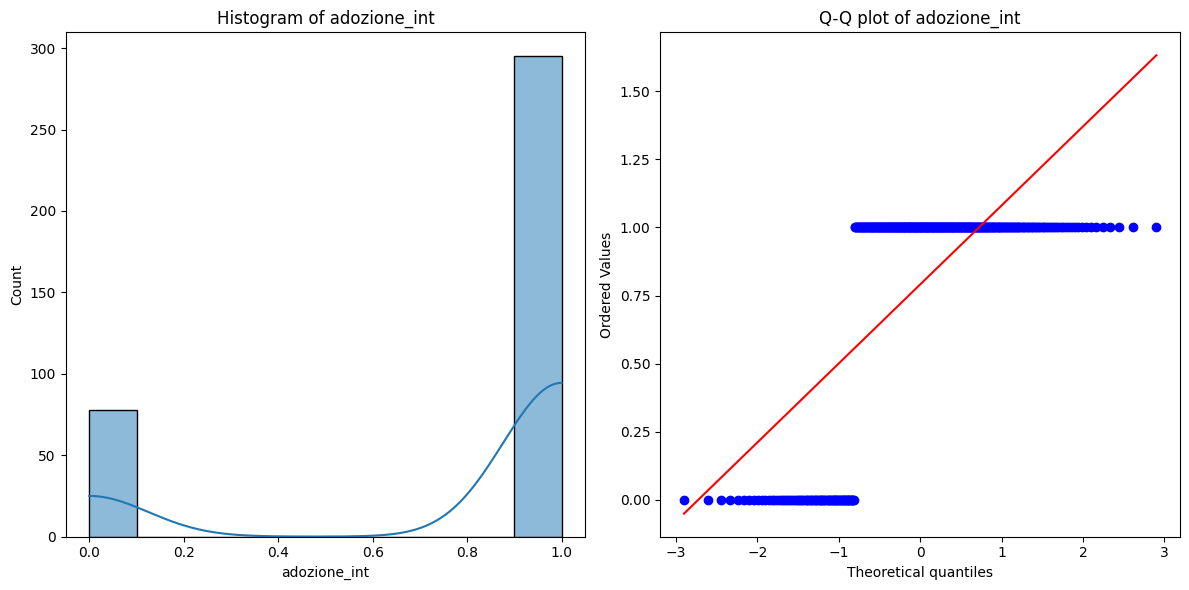

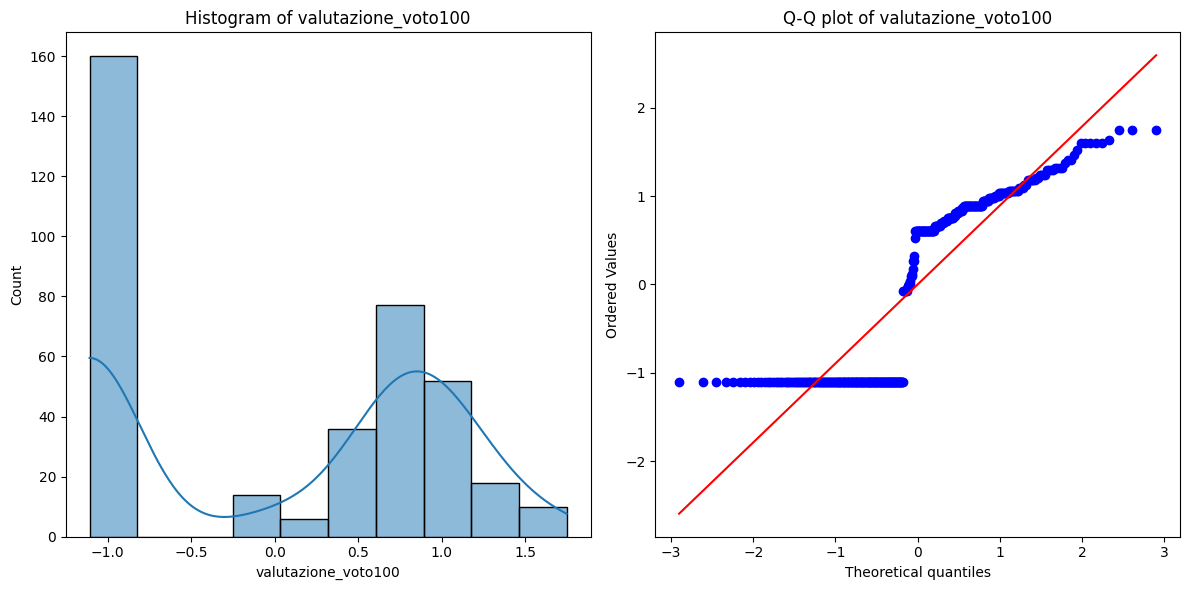

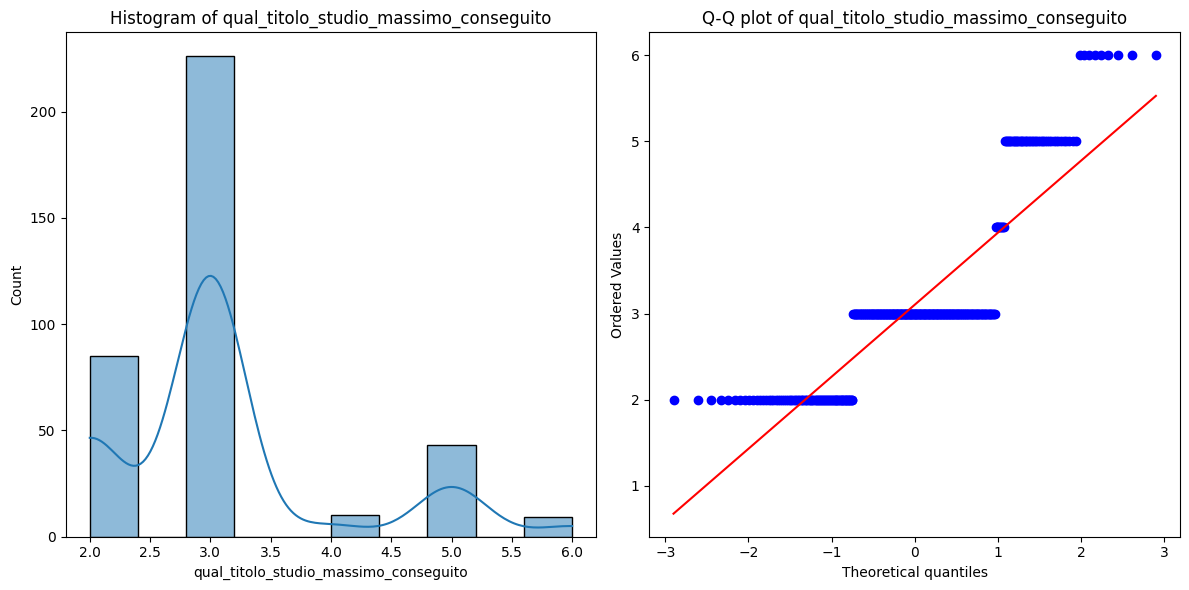

In [42]:
for col in df_cleaned.columns:
    # Histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df_cleaned[col], dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {col}')

    plt.tight_layout()
    plt.show()


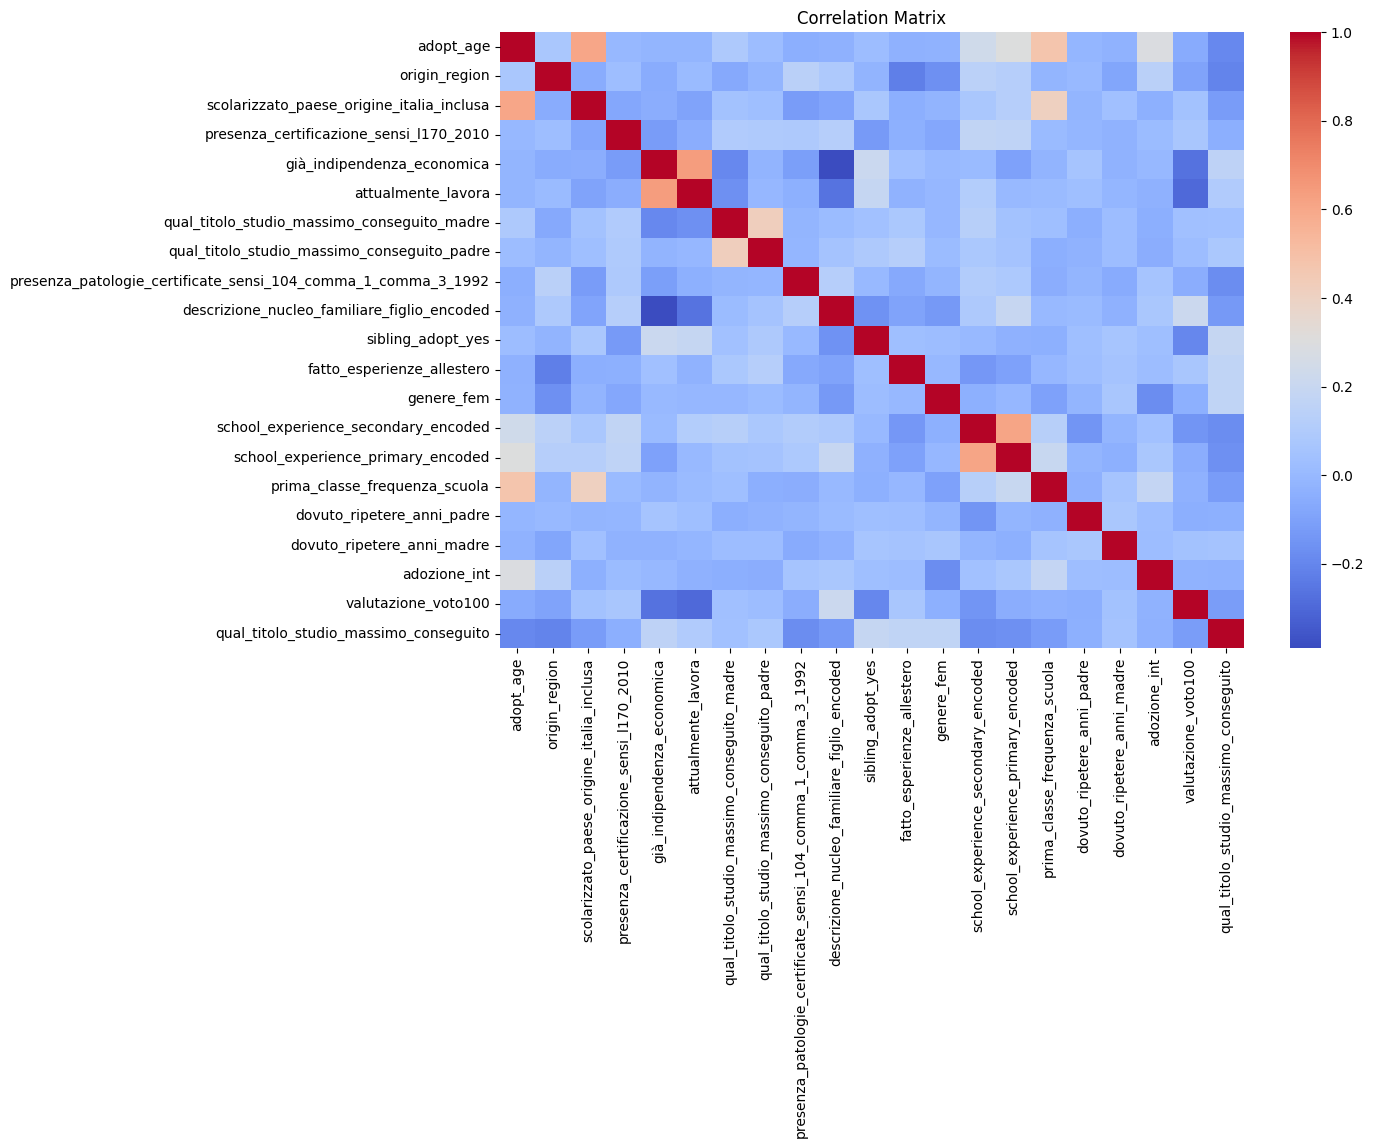

In [43]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


In [44]:
high_vif_columns = ["school_experience_secondary_encoded",
                    "qual_titolo_studio_massimo_conseguito_padre",
                    "origin_region",'descrizione_nucleo_familiare_figlio_encoded','school_experience_primary_encoded']

df_cleaned = df_cleaned.drop(columns=high_vif_columns)


In [45]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['qual_titolo_studio_massimo_conseguito'])
y = df_cleaned['qual_titolo_studio_massimo_conseguito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gauss_markov_assumptions(X_train, y_train)

Durbin-Watson statistic: 1.8887960112581992
Breusch-Pagan Test p-value: 1.9835043066115418e-18

Variance Inflation Factors (VIF):
                                              feature       VIF
0                                           adopt_age  1.832283
1           scolarizzato_paese_origine_italia_inclusa  2.196776
2             presenza_certificazione_sensi_l170_2010  1.187853
3                          già_indipendenza_economica  2.389330
4                                  attualmente_lavora  2.808963
5         qual_titolo_studio_massimo_conseguito_madre  5.210004
6   presenza_patologie_certificate_sensi_104_comma...  1.153451
7                                   sibling_adopt_yes  1.558693
8                          fatto_esperienze_allestero  1.341368
9                                          genere_fem  1.703742
10                      prima_classe_frequenza_scuola  1.487830
11                         dovuto_ripetere_anni_padre  1.085543
12                         dovuto_ripe

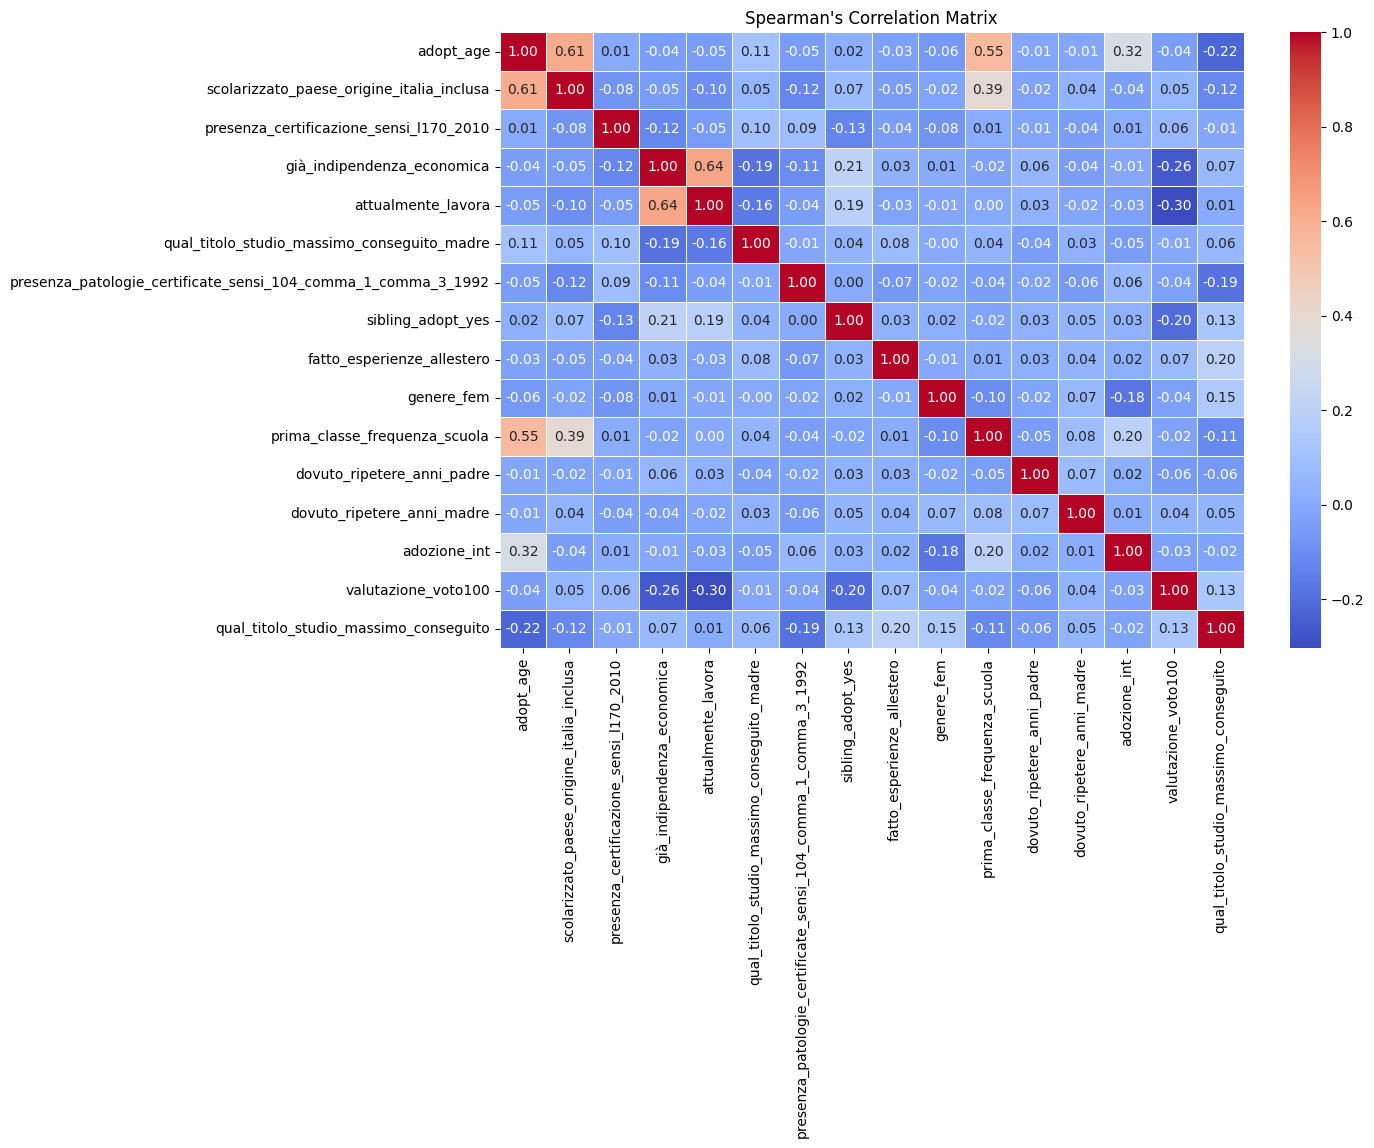

In [46]:
spearman_corr = df_cleaned.corr(method="spearman")

# Plot Spearman's correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()

## Stat Models

In [47]:
from scipy.stats import chi2_contingency

categorical_vars = [col for col in categorical_vars if col in df_cleaned.columns]
for cat_var in categorical_vars:
    try:
        contingency_table = pd.crosstab(df_cleaned[cat_var], df_cleaned[target_variable])
        stat, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-Square Test for Independence between {target_variable} and {cat_var}:")
        print(f"Statistic: {stat}, p-value: {p_value}, Degrees of Freedom: {dof}\n")
    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")


Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and scolarizzato_paese_origine_italia_inclusa:
Statistic: 6.9821361817485466, p-value: 0.13683526317624276, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and presenza_certificazione_sensi_l170_2010:
Statistic: 5.309789187459172, p-value: 0.2569619293541882, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and già_indipendenza_economica:
Statistic: 35.926257125106034, p-value: 2.996555853114448e-07, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and attualmente_lavora:
Statistic: 35.66564106272275, p-value: 3.390157024690225e-07, Degrees of Freedom: 4

Chi-Square Test for Independence between qual_titolo_studio_massimo_conseguito and qual_titolo_studio_massimo_conseguito_madre:
Statistic: 27.954762955703757, p-value: 0.4668468068087901, Degrees of 

In [48]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.9 MB/s eta 0:00:00


In [49]:
for cat_var in categorical_vars:
    try:
        groups = [df_cleaned[df_cleaned[cat_var] == val][target_variable].dropna()
                  for val in df_cleaned[cat_var].unique()]

        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            kruskal_stat, kruskal_p_value = stats.kruskal(*groups)

            print(f"Kruskal-Wallis test result for {target_variable} by {cat_var}:")
            print(f"Statistic: {kruskal_stat}, p-value: {kruskal_p_value}\n")
        else:
            print(f"Skipping {cat_var} - Not enough valid groups for Kruskal-Wallis test.")

    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by scolarizzato_paese_origine_italia_inclusa:
Statistic: 5.010939966073143, p-value: 0.02518762767895624

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by presenza_certificazione_sensi_l170_2010:
Statistic: 0.042787315498427854, p-value: 0.8361262642186363

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by già_indipendenza_economica:
Statistic: 1.668926410248526, p-value: 0.19640239467083426

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by attualmente_lavora:
Statistic: 0.010979568572289922, p-value: 0.9165476534185294

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by qual_titolo_studio_massimo_conseguito_madre:
Statistic: 6.497310056255084, p-value: 0.4830220450878695

Kruskal-Wallis test result for qual_titolo_studio_massimo_conseguito by presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992:
Statistic: 13.06673687339

In [50]:
pip install imbalanced-learn


In [51]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y.values.ravel(), test_size=0.2, random_state=42, stratify=y.values.ravel()
# )

In [52]:
y_train.value_counts()

,count
qual_titolo_studio_massimo_conseguito,
3,181
2,68
5,35
4,8
6,6


In [53]:
from imblearn.combine import SMOTETomek

class_counts = pd.Series(y_train).value_counts()

smote_tomek = SMOTETomek(sampling_strategy="not majority", random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_resampled).value_counts()
print("Class Distribution After Resampling:\n", class_counts_resampled)
resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
resampled_df["qual_titolo_studio_massimo_conseguito"] = y_resampled
class_counts_smote_tomek = pd.Series(y_train).value_counts().sort_index()

Class Distribution After Resampling:
 qual_titolo_studio_massimo_conseguito
5    181
4    181
6    181
3    180
2    180
Name: count, dtype: int64


In [54]:
X_train, y_train = X_resampled, y_resampled

In [55]:
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.miscmodels.ordinal_model import OrderedModel

formula = '''
qual_titolo_studio_massimo_conseguito ~
    adopt_age +
    scolarizzato_paese_origine_italia_inclusa +
    presenza_certificazione_sensi_l170_2010 +
    qual_titolo_studio_massimo_conseguito_madre +
    presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 +
    sibling_adopt_yes +
    fatto_esperienze_allestero +
    genere_fem +
    prima_classe_frequenza_scuola +
    dovuto_ripetere_anni_padre +
    dovuto_ripetere_anni_madre +
    adozione_int +
    valutazione_voto100 - 1
'''

selected_features = [
    "adopt_age",
    "scolarizzato_paese_origine_italia_inclusa",
    "presenza_certificazione_sensi_l170_2010",
    "qual_titolo_studio_massimo_conseguito_madre",
    # "presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    "sibling_adopt_yes",
    "fatto_esperienze_allestero",
    "genere_fem",
    "dovuto_ripetere_anni_madre",
    "adozione_int",
    'attualmente_lavora',
    "valutazione_voto100"
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model_ord = OrderedModel(y_train, X_train_selected, distr='logit')
results = model_ord.fit(maxiter=15000)
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.379098
         Iterations: 5105
         Function evaluations: 6658
                                       OrderedModel Results                                      
Dep. Variable:     qual_titolo_studio_massimo_conseguito   Log-Likelihood:                -1245.3
Model:                                      OrderedModel   AIC:                             2521.
Method:                               Maximum Likelihood   BIC:                             2593.
Date:                                   Sun, 16 Feb 2025                                         
Time:                                           20:38:44                                         
No. Observations:                                    903                                         
Df Residuals:                                        888                                         
Df Model:                                             11                  

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from statsmodels.miscmodels.ordinal_model import OrderedModel

y_train_pred = results.predict(X_train_selected).idxmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)


y_test_pred = results.predict(X_test_selected).idxmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Confusion Matrix:
 [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 7  1  5  0  4  0  0]
 [25  2  9  6  3  0  0]
 [ 1  0  0  1  0  0  0]
 [ 3  1  2  1  1  0  0]
 [ 0  0  0  1  2  0  0]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         0
     Class 1       0.00      0.00      0.00         0
     Class 2       0.31      0.29      0.30        17
     Class 3       0.67      0.13      0.22        45
     Class 4       0.00      0.00      0.00         2
     Class 5       0.00      0.00      0.00         8
     Class 6       0.00      0.00      0.00         3

    accuracy                           0.15        75
   macro avg       0.14      0.06      0.08        75
weighted avg       0.47      0.15      0.20        75

Evaluation Results:
Training Accuracy: 0.0797
Test Accuracy: 0.1467
Training MAE: 1.9380
Test MAE: 2.0533


In [57]:
pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=831eb0872fc92f343c853033ba672cbf919a4ae4b3753f3fc508470660f6e5a9
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [58]:
from mord import LogisticIT, LAD
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report

y_train= y_train.astype(int)
y_test= y_test.astype(int)

def train_and_evaluate(model, model_name):
    model.fit(X_train_selected, y_train)

    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
    conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
    class_report = classification_report(
        y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
    )

    print(f"\nModel: {model_name}")
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("Evaluation Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

models = {
    "LogisticIT": LogisticIT(max_iter= 15000)}
for model_name, model in models.items():
    train_and_evaluate(model, model_name)



Model: LogisticIT
Confusion Matrix:
 [[ 7  1  5  2  2]
 [26  1  3  8  7]
 [ 1  0  0  0  1]
 [ 4  0  1  2  1]
 [ 0  0  1  0  2]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.18      0.41      0.25        17
     Class 3       0.50      0.02      0.04        45
     Class 4       0.00      0.00      0.00         2
     Class 5       0.17      0.25      0.20         8
     Class 6       0.15      0.67      0.25         3

    accuracy                           0.16        75
   macro avg       0.20      0.27      0.15        75
weighted avg       0.37      0.16      0.11        75

Evaluation Results:
Training Accuracy: 0.4197
Test Accuracy: 0.1600
Training MAE: 1.0100
Test MAE: 1.4800


In [274]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2
thresholds = np.unique(y_train)[:-1]
lrt_stats = []
p_values = []

for t in thresholds:
    y_binary = (y_train > t).astype(int)
    model = LogisticRegression(solver='liblinear').fit(X_train, y_binary)
    log_likelihood = model.score(X_train, y_binary) * len(y_train)
    lrt_stats.append(log_likelihood)

lrt_diff = np.diff(lrt_stats)
df_diff = X_train.shape[1]
p_values = [chi2.sf(stat, df_diff) for stat in lrt_diff]

lrt_df = pd.DataFrame({
    "Threshold": thresholds[1:],
    "LRT Statistic": lrt_diff,
    "P-value": p_values
})

print("\nLikelihood Ratio Test for Proportional Odds:\n", lrt_df)

if any(p < 0.05 for p in p_values):
    print("The proportional odds assumption is violated.")
else:
    print("The proportional odds assumption holds.")


Likelihood Ratio Test for Proportional Odds:
    Threshold  LRT Statistic       P-value
0          3            2.0  9.999703e-01
1          4            9.0  8.775175e-01
2          5           60.0  2.522085e-07
The proportional odds assumption is violated.


Multinomial logistic regression

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

log_reg = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l2', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))

conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[10  0  5  1  1]
 [ 1 41  2  1  0]
 [ 1  0  0  1  0]
 [ 3  0  1  3  1]
 [ 0  0  0  1  2]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.67      0.59      0.62        17
     Class 3       1.00      0.91      0.95        45
     Class 4       0.00      0.00      0.00         2
     Class 5       0.43      0.38      0.40         8
     Class 6       0.50      0.67      0.57         3

    accuracy                           0.75        75
   macro avg       0.52      0.51      0.51        75
weighted avg       0.82      0.75      0.78        75

Evaluation Results:
Training Accuracy: 0.8416
Test Accuracy: 0.7467
Training MAE: 0.3688
Test MAE: 0.4933


In [60]:
feature_importance_per_class = pd.DataFrame(log_reg.coef_, columns=X_train.columns)
feature_importance_per_class.index = [f"Class {cls}" for cls in log_reg.classes_]
print("\nFeature Importance Per Class (Coefficients):\n")
print(feature_importance_per_class)


Feature Importance Per Class (Coefficients):

         adopt_age  scolarizzato_paese_origine_italia_inclusa  \
Class 2   1.602717                                   0.607556   
Class 3   0.507440                                   0.330599   
Class 4  -0.115175                                   0.170810   
Class 5   0.398782                                   0.122487   
Class 6  -2.393764                                  -1.231452   

         presenza_certificazione_sensi_l170_2010  già_indipendenza_economica  \
Class 2                                 0.359834                    0.867178   
Class 3                                 0.087567                    0.215986   
Class 4                                 2.760172                   -1.942192   
Class 5                                -0.903173                    1.368879   
Class 6                                -2.304401                   -0.509852   

         attualmente_lavora  qual_titolo_studio_massimo_conseguito_madre  \
Class

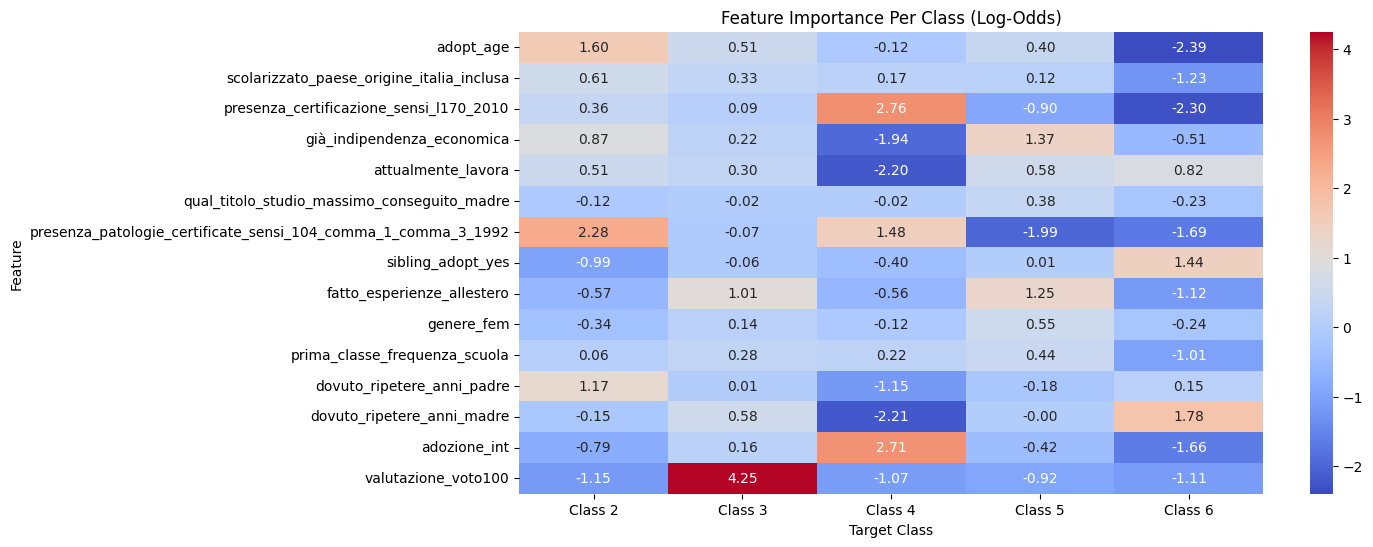

In [61]:
plt.figure(figsize=(12, 6))
sns.heatmap(feature_importance_per_class.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Importance Per Class (Log-Odds)")
plt.xlabel("Target Class")
plt.ylabel("Feature")
plt.show()

In [280]:
model_eqn = "qual_titolo_studio_massimo_conseguito ~ " + " + ".join([
    "adopt_age",
    "presenza_certificazione_sensi_l170_2010",
    "attualmente_lavora",
    "qual_titolo_studio_massimo_conseguito_madre",
    "presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    "sibling_adopt_yes",
    "fatto_esperienze_allestero",
    "genere_fem",
    "prima_classe_frequenza_scuola",
    "adozione_int"
])
model = sm.MNLogit.from_formula(model_eqn, resampled_df).fit_regularized(
    method="l1", alpha=0.1,maxiter=18000, cov_type="HC3")
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.952881156379197
            Iterations: 630
            Function evaluations: 631
            Gradient evaluations: 630


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    MNLogit Regression Results                                   
=================================================================================================
Dep. Variable:     qual_titolo_studio_massimo_conseguito   No. Observations:                  903
Model:                                           MNLogit   Df Residuals:                      860
Method:                                              MLE   Df Model:                           39
Date:                                   Mon, 17 Feb 2025   Pseudo R-squ.:                  0.3970
Time:                                           03:24:03   Log-Likelihood:                -876.40
converged:                                          True   LL-Null:                       -1453.3
Covariance Type:                                     HC3   LLR p-value:                1.259e-216
=================================================================================================================================
                      qual_titolo_studio_massimo_conseguito=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -0.5732      0.533     -1.076      0.282      -1.618       0.471
adopt_age                                                        -0.6955      0.201     -3.461      0.001      -1.089      -0.302
presenza_certificazione_sensi_l170_2010                           0.9911      0.566      1.752      0.080      -0.117       2.100
attualmente_lavora                                               -1.2321      0.317     -3.883      0.000      -1.854      -0.610
qual_titolo_studio_massimo_conseguito_madre                       0.1143      0.095      1.202      0.229      -0.072       0.301
presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992    -1.4595      0.554     -2.637      0.008      -2.544      -0.375
sibling_adopt_yes                                                 0.4457      0.346      1.290      0.197      -0.232       1.123
fatto_esperienze_allestero                                        2.4775      0.576      4.302      0.000       1.349       3.606
genere_fem                                                        0.5321      0.264      2.019      0.044       0.015       1.049
prima_classe_frequenza_scuola                                    -0.0561      0.162     -0.346      0.730      -0.375       0.262
adozione_int                                                      0.4024      0.349      1.153      0.249      -0.281       1.086
---------------------------------------------------------------------------------------------------------------------------------
                      qual_titolo_studio_massimo_conseguito=4       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -8.0048      0.816     -9.805      0.000      -9.605      -6.405
adopt_age                                                        -1.8280      0.235     -7.770      0.000      -2.289      -1.367
presenza_certificazione_sensi_l170_2010                           3.0073      0.585      5.136      0.000       1.860       4.155
attualmente_lavora                                               -3.2362      0.351     -9.223      0.000      -3.924      -2.549
qual_titolo_studio_massimo_conseguito_madre                       0.3124      0.097      3.207      0.001       0.121       0.503
presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992    -0.2191      0.418     -0.524      0.600      -1.038       0.600
sibling_adopt_yes                                                 0.4503      0.

In [282]:
model_eqn = "qual_titolo_studio_massimo_conseguito ~ " + " + ".join([
    "adopt_age",
    "presenza_certificazione_sensi_l170_2010",
    "attualmente_lavora",
    "qual_titolo_studio_massimo_conseguito_madre",
    "presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    "prima_classe_frequenza_scuola",
    "dovuto_ripetere_anni_madre",
    "genere_fem * adozione_int",
    "adozione_int * sibling_adopt_yes"
])
model = sm.MNLogit.from_formula(model_eqn, resampled_df).fit_regularized(
    method="l1", alpha=0.1, maxiter=18000, cov_type="HC3"
)
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.909816103183046
            Iterations: 751
            Function evaluations: 752
            Gradient evaluations: 751


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    MNLogit Regression Results                                   
=================================================================================================
Dep. Variable:     qual_titolo_studio_massimo_conseguito   No. Observations:                  903
Model:                                           MNLogit   Df Residuals:                      855
Method:                                              MLE   Df Model:                           44
Date:                                   Mon, 17 Feb 2025   Pseudo R-squ.:                  0.4100
Time:                                           03:27:25   Log-Likelihood:                -857.52
converged:                                          True   LL-Null:                       -1453.3
Covariance Type:                                     HC3   LLR p-value:                6.824e-221
=================================================================================================================================
                      qual_titolo_studio_massimo_conseguito=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -0.4910      0.558     -0.880      0.379      -1.584       0.602
adopt_age                                                        -0.7481      0.205     -3.641      0.000      -1.151      -0.345
presenza_certificazione_sensi_l170_2010                           0.9505      0.586      1.621      0.105      -0.199       2.100
attualmente_lavora                                               -1.1966      0.321     -3.724      0.000      -1.826      -0.567
qual_titolo_studio_massimo_conseguito_madre                       0.1269      0.093      1.361      0.174      -0.056       0.310
presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992    -1.5497      0.566     -2.740      0.006      -2.658      -0.441
prima_classe_frequenza_scuola                                    -0.0514      0.165     -0.312      0.755      -0.374       0.271
dovuto_ripetere_anni_madre                                        0.1095      0.405      0.270      0.787      -0.685       0.904
genere_fem                                                        0.6474      0.655      0.989      0.323      -0.636       1.930
adozione_int                                                      0.4676      0.448      1.043      0.297      -0.411       1.347
genere_fem:adozione_int                                          -0.0920      0.730     -0.126      0.900      -1.523       1.339
sibling_adopt_yes                                                -0.2897      0.922     -0.314      0.753      -2.097       1.518
adozione_int:sibling_adopt_yes                                    1.0492      0.999      1.050      0.294      -0.909       3.007
---------------------------------------------------------------------------------------------------------------------------------
                      qual_titolo_studio_massimo_conseguito=4       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -8.4058      0.888     -9.461      0.000     -10.147      -6.664
adopt_age                                                        -1.9324      0.242     -7.969      0.000      -2.408      -1.457
presenza_certificazione_sensi_l170_2010                           2.8604      0.633      4.520      0.000       1.620       4.101
attualmente_lavora                                               -3.5259      0.372     -9.476      0.000      -4.255      -2.797
qual_titolo_studio_massimo_conseguito_madre                       0.3729      0.

### SEM

In [65]:
!pip install semopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 7.4 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=e12e39dbfa38d91ee030291157b1790cb0ce384b08d20d04859841fd87cb7a2e
  Stored in directory: /root/.cache/pip/wheels/d2/9a/31/fae291ff6a649bad125037eef8c7cc63d8c542e14bdcccea37
Successfully built semopy


In [234]:
from semopy import Model
sem_model_desc = """
qual_titolo_studio_massimo_conseguito ~ adopt_age + scolarizzato_paese_origine_italia_inclusa + presenza_certificazione_sensi_l170_2010 + già_indipendenza_economica + attualmente_lavora + qual_titolo_studio_massimo_conseguito_madre + presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + sibling_adopt_yes + fatto_esperienze_allestero + genere_fem + prima_classe_frequenza_scuola + dovuto_ripetere_anni_padre + dovuto_ripetere_anni_madre + adozione_int + valutazione_voto100
"""
model = Model(sem_model_desc)
model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,qual_titolo_studio_massimo_conseguito,~,adopt_age,-0.206051,0.066139,-3.115416,0.001837
1,qual_titolo_studio_massimo_conseguito,~,scolarizzato_paese_origine_italia_inclusa,0.002205,0.136467,0.016155,0.987111
2,qual_titolo_studio_massimo_conseguito,~,presenza_certificazione_sensi_l170_2010,0.050704,0.129850,0.390485,0.696178
3,qual_titolo_studio_massimo_conseguito,~,già_indipendenza_economica,0.195727,0.139480,1.403259,0.160540
4,qual_titolo_studio_massimo_conseguito,~,attualmente_lavora,-0.000858,0.122281,-0.007014,0.994404
5,qual_titolo_studio_massimo_conseguito,~,qual_titolo_studio_massimo_conseguito_madre,0.035505,0.031399,1.130737,0.258166
6,qual_titolo_studio_massimo_conseguito,~,presenza_patologie_certificate_sensi_104_comma...,-0.539966,0.146241,-3.692304,0.000222
7,qual_titolo_studio_massimo_conseguito,~,sibling_adopt_yes,0.316039,0.109328,2.890749,0.003843
8,qual_titolo_studio_massimo_conseguito,~,fatto_esperienze_allestero,0.332360,0.110465,3.008732,0.002623
9,qual_titolo_studio_massimo_conseguito,~,genere_fem,0.308750,0.093675,3.295958,0.000981


In [249]:
sem_model_desc = """
personal =~ genere_fem + adopt_age + adozione_int
school =~ prima_classe_frequenza_scuola + fatto_esperienze_allestero + scolarizzato_paese_origine_italia_inclusa
family =~ qual_titolo_studio_massimo_conseguito_madre + dovuto_ripetere_anni_madre+sibling_adopt_yes

qual_titolo_studio_massimo_conseguito ~ personal + school + family
qual_titolo_studio_massimo_conseguito ~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + presenza_certificazione_sensi_l170_2010
school ~ family
school ~~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + presenza_certificazione_sensi_l170_2010

"""
model = Model(sem_model_desc)
model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,school,~,family,4.496801e+00,3.262584,1.378294,0.168112
1,genere_fem,~,personal,1.000000e+00,-,-,-
2,adopt_age,~,personal,-2.197937e+01,13.490774,-1.629215,0.103268
3,adozione_int,~,personal,-2.060625e+00,1.245797,-1.654062,0.098115
4,prima_classe_frequenza_scuola,~,school,1.000000e+00,-,-,-
5,fatto_esperienze_allestero,~,school,-3.058988e-02,0.040842,-0.748981,0.453869
6,scolarizzato_paese_origine_italia_inclusa,~,school,5.410186e-01,0.057375,9.42951,0.0
7,qual_titolo_studio_massimo_conseguito_madre,~,family,1.000000e+00,-,-,-
8,dovuto_ripetere_anni_madre,~,family,5.392621e-02,0.172569,0.312492,0.754667
9,sibling_adopt_yes,~,family,8.456329e-02,0.212378,0.398174,0.690502


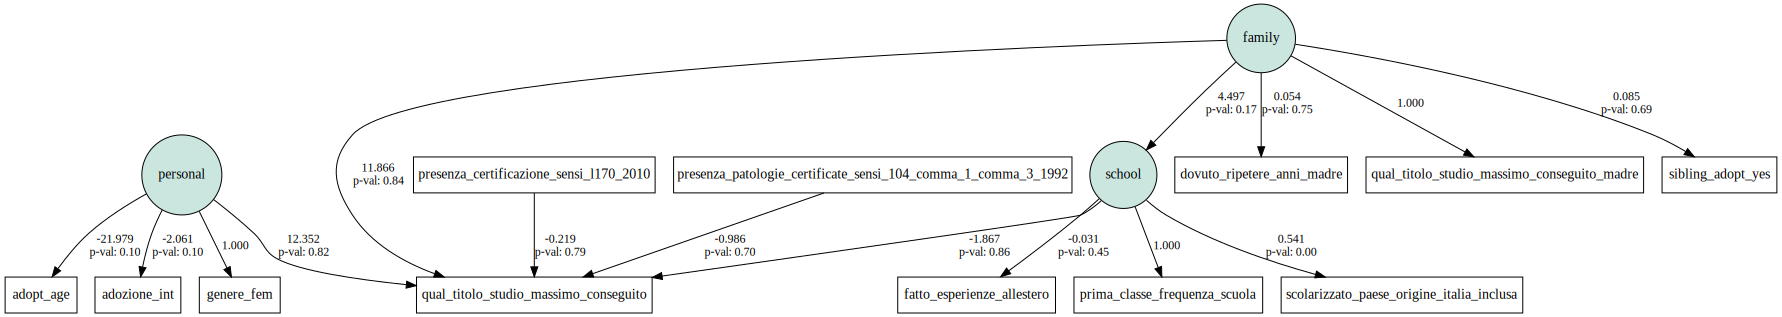

In [250]:
from semopy import calc_stats, semplot

semplot(model, filename='t.pdf')

In [251]:
from semopy import calc_stats

calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,50,68,94.542362,0.000144,435.819897,0.878902,0.78307,0.704975,0.78307,0.835306,0.048936,55.283718,165.087914,0.358141


In [254]:
sem_model_desc = """
personal =~ genere_fem + fatto_esperienze_allestero + adozione_int
school =~ prima_classe_frequenza_scuola + fatto_esperienze_allestero
family =~ qual_titolo_studio_massimo_conseguito_madre + dovuto_ripetere_anni_madre+sibling_adopt_yes


qual_titolo_studio_massimo_conseguito ~ personal + school + family
qual_titolo_studio_massimo_conseguito ~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + presenza_certificazione_sensi_l170_2010
school ~ personal

school ~~ family
school ~~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + presenza_certificazione_sensi_l170_2010
"""
model = Model(sem_model_desc)
model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,school,~,personal,-1.887224,0.744544,-2.53474,0.011253
1,genere_fem,~,personal,1.000000,-,-,-
2,fatto_esperienze_allestero,~,personal,4.100854,7.296414,0.562037,0.574091
3,fatto_esperienze_allestero,~,school,2.177310,4.124608,0.527883,0.597581
4,adozione_int,~,personal,-0.755108,0.269893,-2.79781,0.005145
5,prima_classe_frequenza_scuola,~,school,1.000000,-,-,-
6,qual_titolo_studio_massimo_conseguito_madre,~,family,1.000000,-,-,-
7,dovuto_ripetere_anni_madre,~,family,0.282737,0.260269,1.086328,0.277334
8,sibling_adopt_yes,~,family,0.737490,0.562543,1.310994,0.18986
9,qual_titolo_studio_massimo_conseguito,~,personal,0.782935,24.652243,0.031759,0.974664


In [255]:
calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,29,47,34.470377,0.222459,123.164741,0.928177,0.720128,0.546414,0.720128,0.883597,0.022518,51.811328,153.772367,0.094336


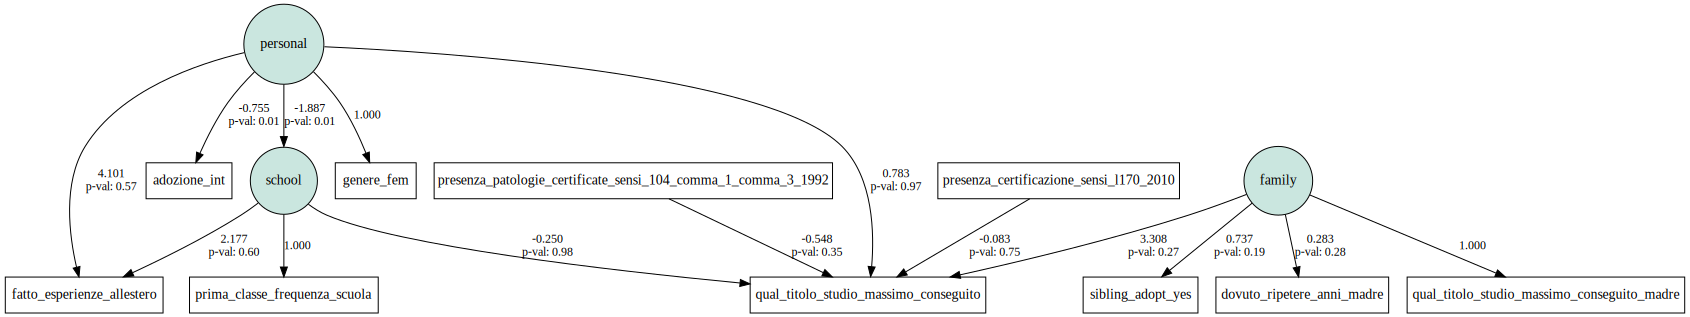

In [256]:
semplot(model, filename='t.pdf')

In [267]:
desc3 = """
family_structure =~ sibling_adopt_yes + qual_titolo_studio_massimo_conseguito_madre + dovuto_ripetere_anni_padre
personal =~ genere_fem + adopt_age + fatto_esperienze_allestero + adozione_int
cognitive_ability =~ presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + presenza_certificazione_sensi_l170_2010

personal ~~ family_structure
cognitive_ability ~~ personal

qual_titolo_studio_massimo_conseguito ~ family_structure + cognitive_ability + personal
"""

model3 = Model(desc3)
model3.fit(resampled_df, obj="ULS", solver="SLSQP")
model3.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,sibling_adopt_yes,~,family_structure,1.000000e+00,-,-,-
1,qual_titolo_studio_massimo_conseguito_madre,~,family_structure,-5.661434e+00,1.389083,-4.075662,0.000046
2,dovuto_ripetere_anni_padre,~,family_structure,1.349928e+00,0.333802,4.0441,0.000053
3,genere_fem,~,personal,1.000000e+00,-,-,-
4,adopt_age,~,personal,-9.759721e+00,2.600409,-3.753149,0.000175
5,fatto_esperienze_allestero,~,personal,-9.677029e-02,0.177142,-0.546287,0.584868
6,adozione_int,~,personal,-2.524169e+00,0.688978,-3.663646,0.000249
7,presenza_patologie_certificate_sensi_104_comma...,~,cognitive_ability,1.000000e+00,-,-,-
8,presenza_certificazione_sensi_l170_2010,~,cognitive_ability,9.976867e-01,0.203875,4.893626,0.000001
9,qual_titolo_studio_massimo_conseguito,~,family_structure,-3.031078e+01,116.419638,-0.260358,0.794588


In [268]:
calc_stats(model3)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,30,45,36.489844,0.192475,1064.491629,0.993634,0.965721,0.948581,0.965721,0.990451,0.015486,49.282014,169.425078,0.358993


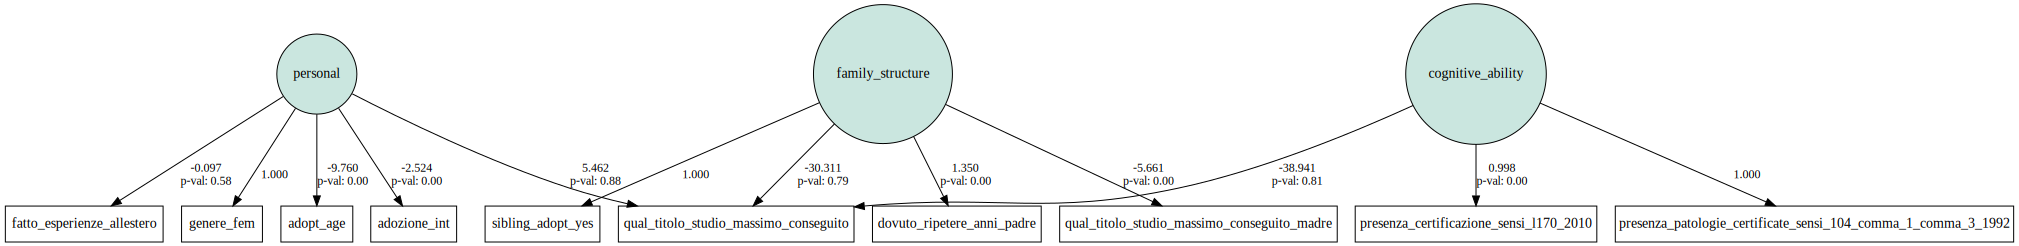

In [269]:
semplot(model3, filename='t.pdf')

In [76]:
# # Latent Class Analysis
# from sklearn.mixture import GaussianMixture

# lca_vars = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# lca_model = GaussianMixture(n_components=7, covariance_type="diag", random_state=42)
# df_cleaned["Latent_Class"] = lca_model.fit_predict(df_cleaned[lca_vars])
# lca_results = df_cleaned[["Latent_Class"] + list(lca_vars)]
# print("\nLCA Classification Results:\n")
# print(lca_results.head(30))

### Non-Param.

In [77]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [171]:
from catboost import CatBoostClassifier
from collections import Counter

cat_model = CatBoostClassifier(
    loss_function='MultiClass',
    iterations=2200,
    depth=3,
    learning_rate=0.005,
    l2_leaf_reg=150,
    random_seed=42,
    early_stopping_rounds=10,
    auto_class_weights="Balanced",
    bagging_temperature=15,
    random_strength=20,
    verbose=False,
    eval_metric="TotalF1"
)

cat_model.fit(X_train, y_train)
y_train_pred_cat = cat_model.predict(X_train)
y_test_pred_cat = cat_model.predict(X_test)


train_accuracy_cat = accuracy_score(y_train, y_train_pred_cat)
test_accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
train_mae_cat = mean_absolute_error(y_train, y_train_pred_cat)
test_mae_cat = mean_absolute_error(y_test, y_test_pred_cat)


conf_matrix_cat = confusion_matrix(y_test, y_test_pred_cat, labels=np.unique(y_test))
class_report_cat = classification_report(
    y_test, y_test_pred_cat, target_names=[f"Class {i}" for i in np.unique(y_test)], zero_division=0
)

print("\nCatBoost Results:")
print("Confusion Matrix:\n", conf_matrix_cat)
print("\nClassification Report:\n", class_report_cat)
print(f"Training Accuracy: {train_accuracy_cat:.4f}")
print(f"Test Accuracy: {test_accuracy_cat:.4f}")
print(f"Training MAE: {train_mae_cat:.4f}")
print(f"Test MAE: {test_mae_cat:.4f}")



CatBoost Results:
Confusion Matrix:
 [[ 7  0  6  2  2]
 [ 0 40  2  1  2]
 [ 1  0  1  0  0]
 [ 1  0  2  4  1]
 [ 0  0  0  1  2]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.78      0.41      0.54        17
     Class 3       1.00      0.89      0.94        45
     Class 4       0.09      0.50      0.15         2
     Class 5       0.50      0.50      0.50         8
     Class 6       0.29      0.67      0.40         3

    accuracy                           0.72        75
   macro avg       0.53      0.59      0.51        75
weighted avg       0.84      0.72      0.76        75

Training Accuracy: 0.7752
Test Accuracy: 0.7200
Training MAE: 0.4563
Test MAE: 0.6000


In [172]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Cross-validation accuracy: 0.7586 ± 0.0244


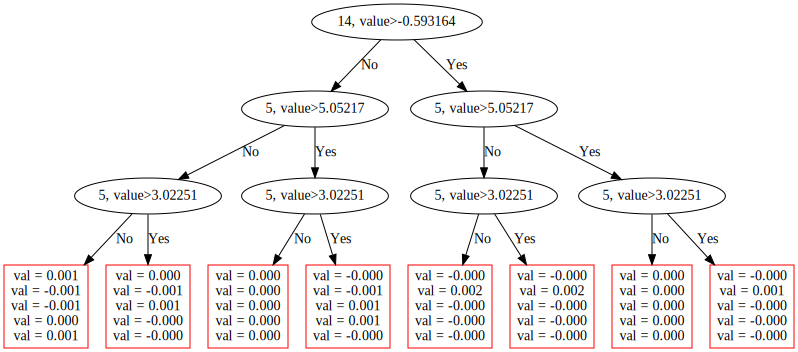

In [180]:
cat_model.plot_tree(
    tree_idx=100)

In [174]:
catboost_features = cat_model.feature_names_
feature_importances = cat_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': catboost_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
14,valutazione_voto100,30.033879
0,adopt_age,20.932221
4,attualmente_lavora,8.402160
5,qual_titolo_studio_massimo_conseguito_madre,7.883730
3,già_indipendenza_economica,7.420236
10,prima_classe_frequenza_scuola,6.471209
2,presenza_certificazione_sensi_l170_2010,4.602000
12,dovuto_ripetere_anni_madre,3.566802
13,adozione_int,2.723282
6,presenza_patologie_certificate_sensi_104_comma...,2.451499


In [181]:
pip install shap

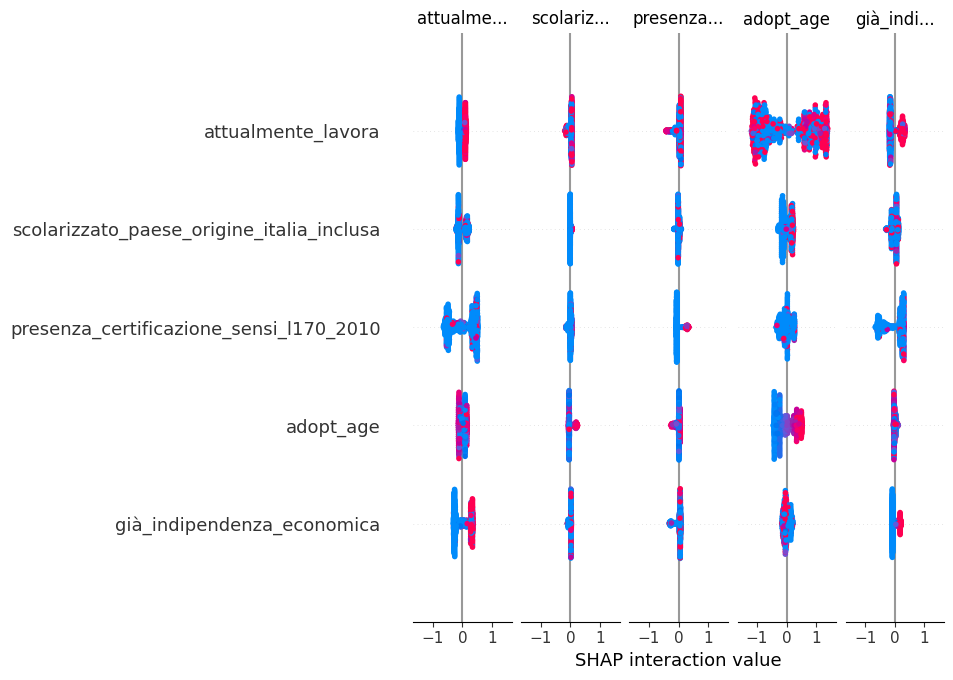

In [182]:
import shap
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

SVM

Fitting 10 folds for each of 6 candidates, totalling 60 fits

Final Train ROC AUC: 0.927
Final Test ROC AUC: 0.8638
Overfitting Gap (AUC): 0.0632
Best Parameters: {'svm__C': 0.04, 'svm__kernel': 'rbf'}


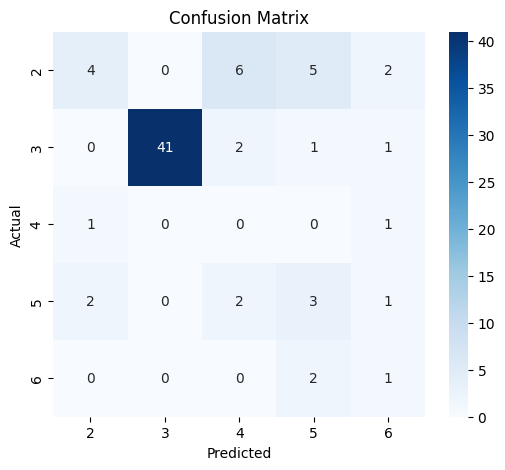


Classification Report:
               precision    recall  f1-score   support

     Class 2       0.57      0.24      0.33        17
     Class 3       1.00      0.91      0.95        45
     Class 4       0.00      0.00      0.00         2
     Class 5       0.27      0.38      0.32         8
     Class 6       0.17      0.33      0.22         3

    accuracy                           0.65        75
   macro avg       0.40      0.37      0.36        75
weighted avg       0.77      0.65      0.69        75


Per-Class Precision:  [0.571 1.    0.    0.273 0.167]
Per-Class Recall:  [0.235 0.911 0.    0.375 0.333]
Per-Class F1 Score:  [0.333 0.953 0.    0.316 0.222]

Weighted Precision:  0.765
Weighted Recall:  0.653
Weighted F1 Score:  0.69


In [230]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_fscore_support
)

selector = SelectFromModel(SVC(kernel="linear", C=0.05, random_state=42))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_feature_names = X_train.columns[selector.get_support()]
pipeline = Pipeline([
    ('svm', SVC(probability=True, random_state=42, class_weight={2:5, 3:1, 4:10, 5:10, 6:10}))
])

param_grid = {
    'svm__C': [0.02, 0.03, 0.04],
    'svm__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=10, scoring='roc_auc_ovr',
    refit=True, n_jobs=-1, verbose=1
)

grid_search.fit(X_train_selected, y_train)
best_svm = grid_search.best_estimator_

y_train_proba = best_svm.predict_proba(X_train_selected)
y_test_proba = best_svm.predict_proba(X_test_selected)
train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr')
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
overfitting_gap = abs(train_auc - test_auc)

print("\nFinal Train ROC AUC:", round(train_auc, 4))
print("Final Test ROC AUC:", round(test_auc, 4))
print("Overfitting Gap (AUC):", round(overfitting_gap, 4))
print("Best Parameters:", grid_search.best_params_)
y_pred = best_svm.predict(X_test_selected)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)], zero_division=0))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
print("\nPer-Class Precision: ", np.round(precision, 3))
print("Per-Class Recall: ", np.round(recall, 3))
print("Per-Class F1 Score: ", np.round(f1_score, 3))

precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
print("\nWeighted Precision: ", round(precision_w, 3))
print("Weighted Recall: ", round(recall_w, 3))
print("Weighted F1 Score: ", round(f1_w, 3))

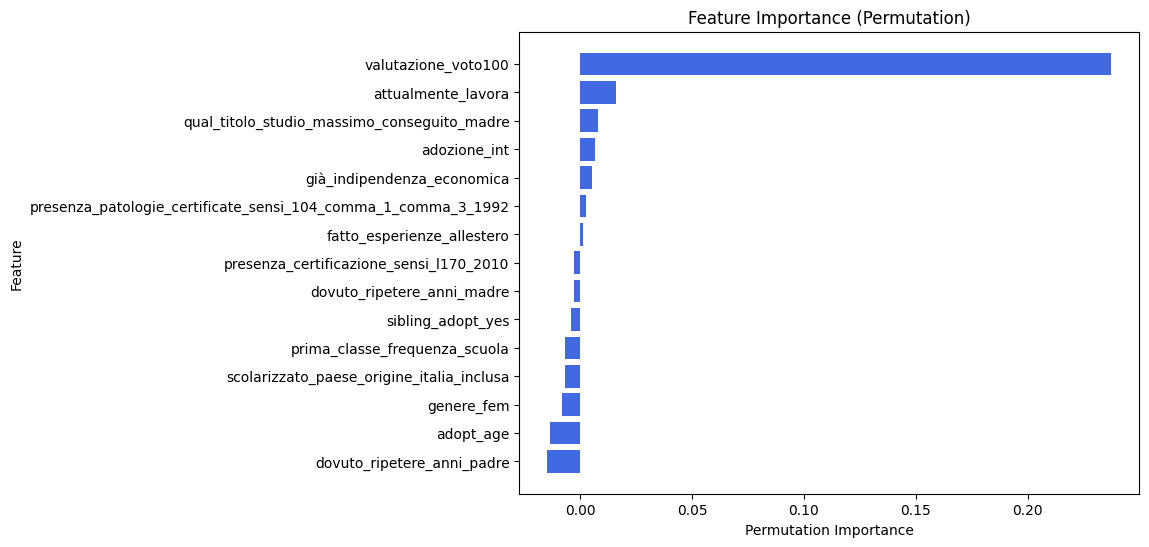

Feature Importance (Sorted):
valutazione_voto100: 0.2373
attualmente_lavora: 0.0160
qual_titolo_studio_massimo_conseguito_madre: 0.0080
adozione_int: 0.0067
già_indipendenza_economica: 0.0053
presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992: 0.0027
fatto_esperienze_allestero: 0.0013
presenza_certificazione_sensi_l170_2010: -0.0027
dovuto_ripetere_anni_madre: -0.0027
sibling_adopt_yes: -0.0040
prima_classe_frequenza_scuola: -0.0067
scolarizzato_paese_origine_italia_inclusa: -0.0067
genere_fem: -0.0080
adopt_age: -0.0133
dovuto_ripetere_anni_padre: -0.0147


In [233]:
from sklearn.inspection import permutation_importance
svc = SVC(kernel='rbf', C=0.04)
svc.fit(X_train, y_train)

perm_importance = permutation_importance(svc, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42, n_jobs=-1)
feature_names = X_train.columns.to_list()
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], color='royalblue')
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation)")
plt.show()
sorted_importance = {features[i]: perm_importance.importances_mean[i] for i in sorted_idx[::-1]}
print("Feature Importance (Sorted):")
for feature, importance in sorted_importance.items():
    print(f"{feature}: {importance:.4f}")
